In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math 
import pylab 

from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
from glob import glob
from os import path
from collections import defaultdict
from skspatial.objects import Plane
from skspatial.objects import Points
from skspatial.plotting import plot_3d
from virocon import (
    GlobalHierarchicalModel,
    ExponentiatedWeibullDistribution,
    WeibullDistribution,
    DependenceFunction,
    WidthOfIntervalSlicer,
    plot_marginal_quantiles,
    plot_dependence_functions,
    _fitting
)

from virocon._fitting import (
    fit_function,
    fit_constrained_function,
    convert_bounds_for_curve_fit,
)

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

# Data

In [2]:
# Read data

data = pd.read_csv('/Volumes/MASTERTHESE/MasterThese/data_unsorted.csv')
data= data.drop(columns=['Unnamed: 0'])
data= data.rename(columns={"peakDeflection": "peakDeflectionSBIT"})
print(data)

      windSpeed  waveHeight  waveTp  waveTz  peakDeflectionSBIT  \
0      4.064444        1.39    7.14   5.263              2.7032   
1      3.959574        1.39    7.14   5.263              2.7870   
2      3.863043        1.39    7.14   5.263              3.6654   
3      3.744186        1.39    7.14   5.263              3.7484   
4      3.872340        1.39    7.14   5.263              4.8689   
...         ...         ...     ...     ...                 ...   
1267   3.991071        0.43    5.88   3.030              4.7862   
1268   4.268966        0.43    5.88   3.030              2.1788   
1269   3.841071        0.43    5.88   3.030              3.7424   
1270   4.678333        0.43    5.88   3.030              1.4381   
1271   4.188136        0.43    5.88   3.030              1.6619   

      peakDeflectionTower  
0                 15.6301  
1                 17.3423  
2                 14.7588  
3                 22.1884  
4                 15.9363  
...                   ...  

# Histogram

In [3]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 40, 80)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# fit GEV and weibull distribution to data
gev_fit_tower= stats.genextreme.fit(data.peakDeflectionTower)
gev_pdf_tower= stats.genextreme.pdf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])
gev_ppf_tower= stats.genextreme.ppf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])
gev_cdf_tower= stats.genextreme.cdf(bin_centers, gev_fit_tower[0], loc= gev_fit_tower[1], scale= gev_fit_tower[2])

#weib_fit = stats.weibull_min.fit(data.deflection)
#weib_cdf= stats.weibull_min.cdf(bin_centers, weib_fit[0], loc= weib_fit[1], scale= weib_fit[2])

#print(weib_fit)
print(gev_fit_tower)

(0.042595420167746034, 8.0698354117348, 4.966140930942613)


<IPython.core.display.Javascript object>


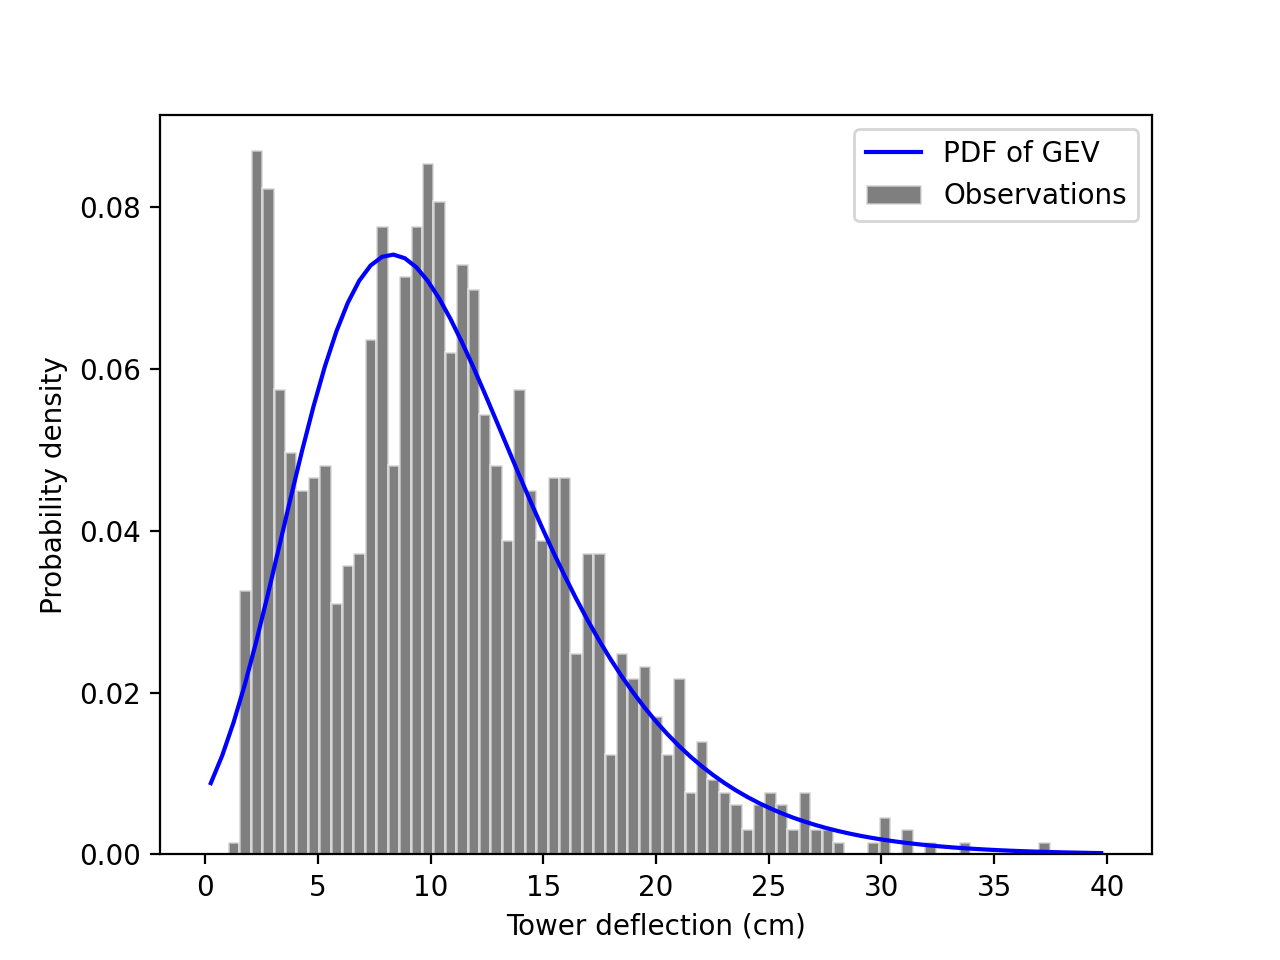

In [4]:
fig, ax1 = plt.subplots()

ax1.hist(data.peakDeflectionTower, bins=bins, label='Observations', color='k', density= 'true', stacked='true', edgecolor='w', alpha= 0.5)
ax1.plot(bin_centers, gev_pdf_tower, label="PDF of GEV", color='b')
ax1.set_xlabel('Tower deflection (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


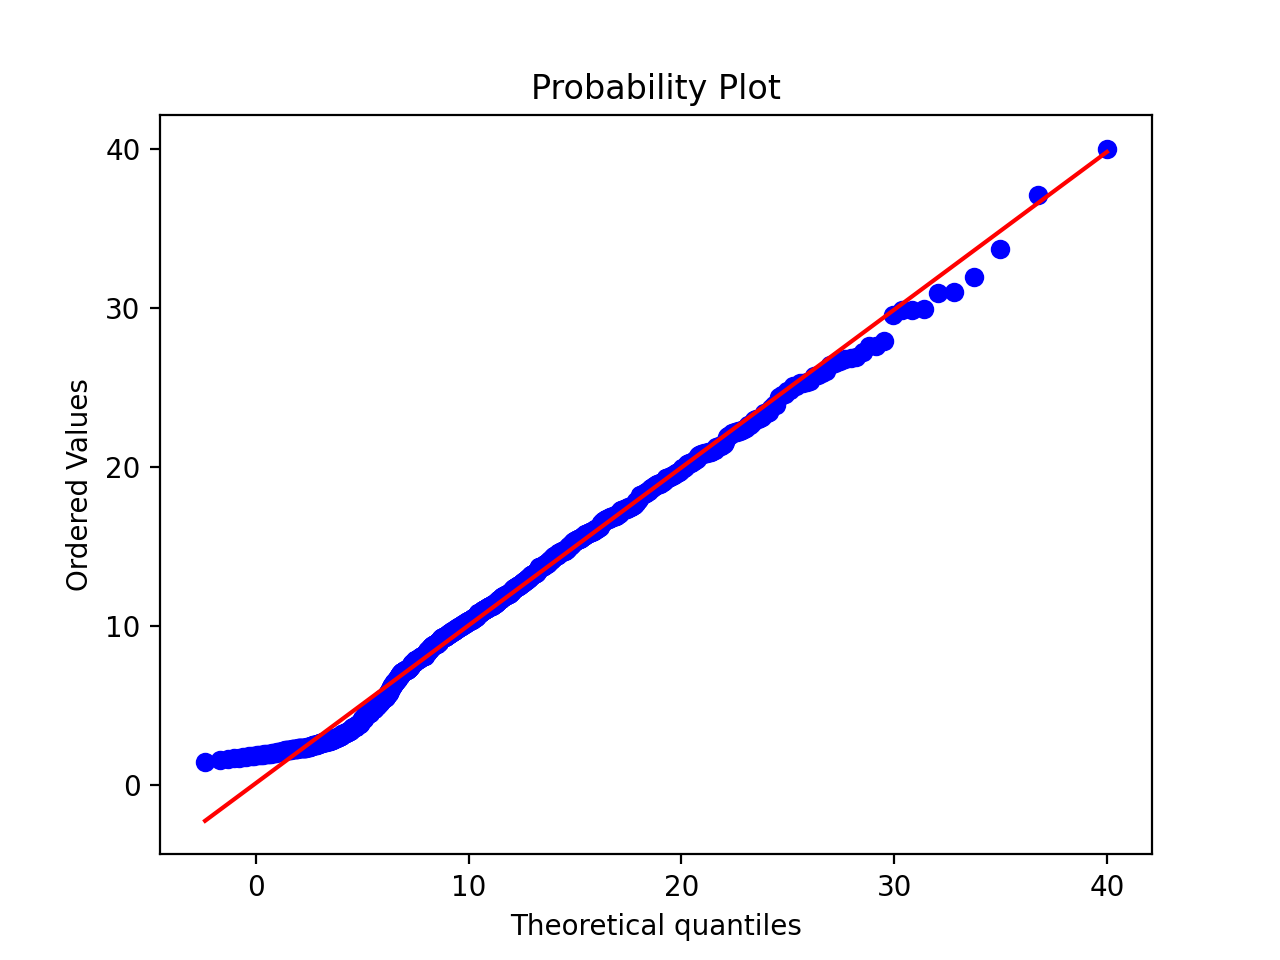

In [9]:
plt.figure()
stats.probplot(data.peakDeflectionTower, (gev_fit_tower[0], gev_fit_tower[1], gev_fit_tower[2]), dist='genextreme', plot=pylab)
pylab.show()

In [6]:
#is_bigger_deflection =  data['peakDeflectionTower']> 5
#data2= data[is_bigger_deflection]

data2 = data.drop(data[data.peakDeflectionTower < 5].index)
data2= data2.reset_index(drop=True)
print(data2)

      windSpeed  waveHeight  waveTp  waveTz  peakDeflectionSBIT  \
0      4.064444        1.39    7.14   5.263              2.7032   
1      3.959574        1.39    7.14   5.263              2.7870   
2      3.863043        1.39    7.14   5.263              3.6654   
3      3.744186        1.39    7.14   5.263              3.7484   
4      3.872340        1.39    7.14   5.263              4.8689   
...         ...         ...     ...     ...                 ...   
1013   5.065517        0.54    4.35   3.361              3.2296   
1014   4.550000        0.44    3.23   3.200              1.4200   
1015   3.963333        0.44    3.23   3.200              1.1627   
1016   3.800000        0.43    5.88   3.030              1.4721   
1017   4.268966        0.43    5.88   3.030              2.1788   

      peakDeflectionTower  
0                 15.6301  
1                 17.3423  
2                 14.7588  
3                 22.1884  
4                 15.9363  
...                   ...  

# Alternative Dependency

In [7]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 40, 80)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# fit GEV and weibull distribution to data
gev_fit_tower2= stats.genextreme.fit(data2.peakDeflectionTower)
gev_pdf_tower2= stats.genextreme.pdf(bin_centers, gev_fit_tower2[0], loc= gev_fit_tower2[1], scale= gev_fit_tower2[2])
gev_ppf_tower2= stats.genextreme.ppf(bin_centers, gev_fit_tower2[0], loc= gev_fit_tower2[1], scale= gev_fit_tower2[2])
gev_cdf_tower2= stats.genextreme.cdf(bin_centers, gev_fit_tower2[0], loc= gev_fit_tower2[1], scale= gev_fit_tower2[2])

#weib_fit = stats.weibull_min.fit(data.deflection)
#weib_cdf= stats.weibull_min.cdf(bin_centers, weib_fit[0], loc= weib_fit[1], scale= weib_fit[2])

#print(weib_fit)
print(gev_fit_tower2)

(-0.06781267681882906, 10.191090836586008, 3.7876626437533893)


<IPython.core.display.Javascript object>


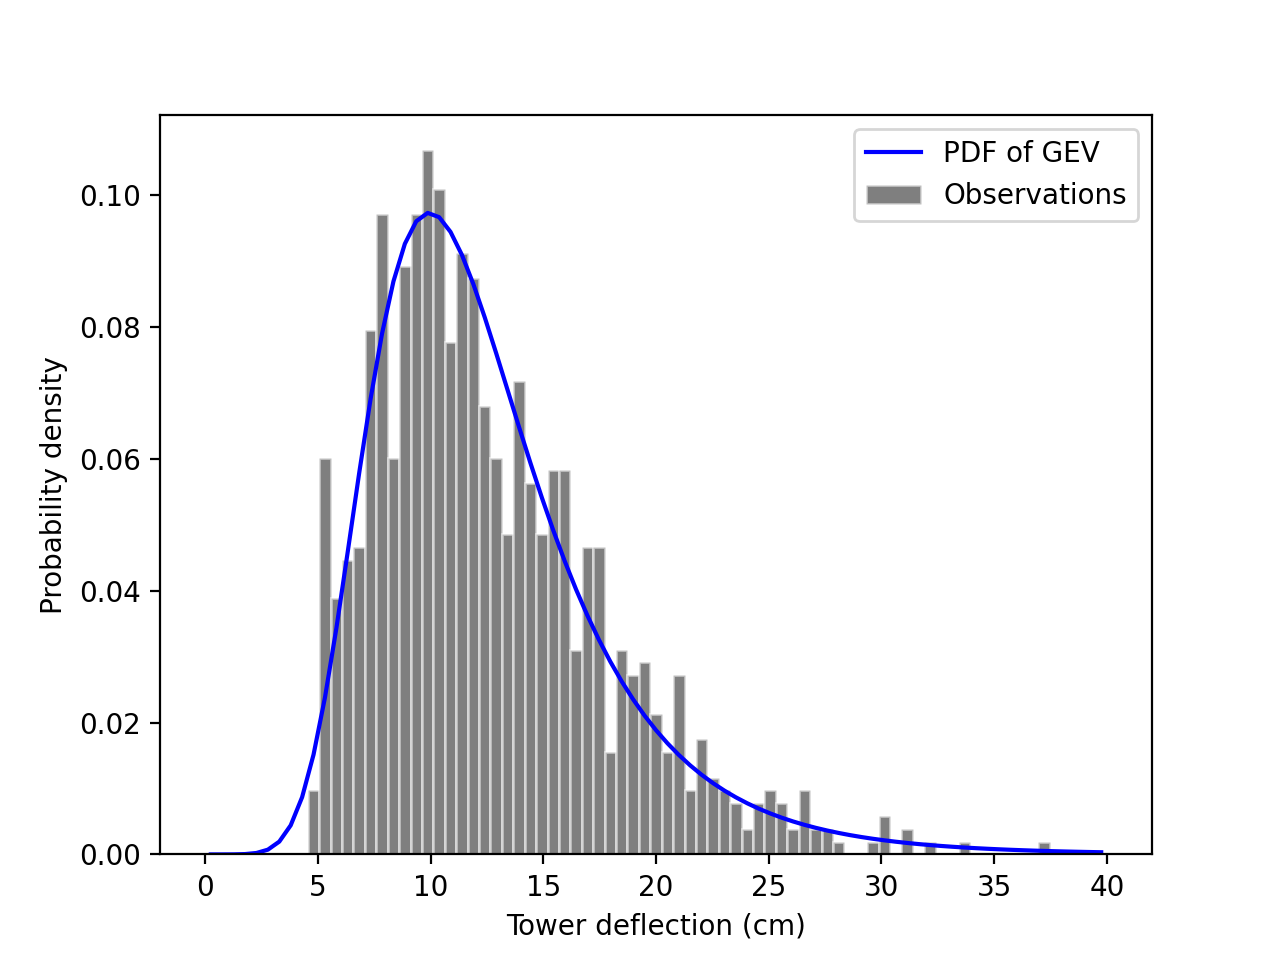

In [8]:
fig, ax1 = plt.subplots()

ax1.hist(data2.peakDeflectionTower, bins=bins, label='Observations', color='k', alpha= 0.5, density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, gev_pdf_tower2, label="PDF of GEV", color='b')
ax1.set_xlabel('Tower deflection (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


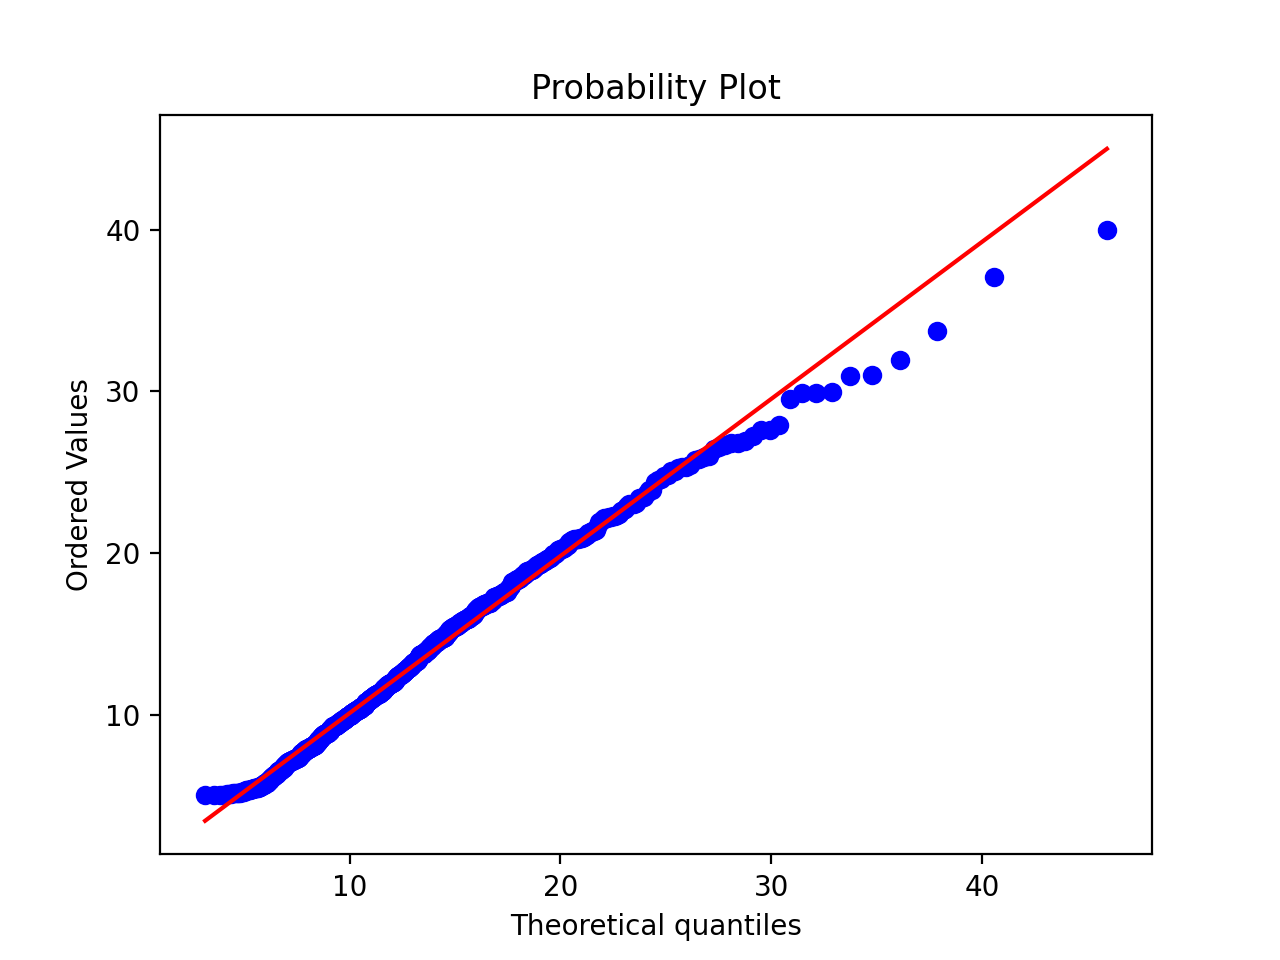

In [10]:
plt.figure()
stats.probplot(data2.peakDeflectionTower, (gev_fit_tower2[0], gev_fit_tower2[1], gev_fit_tower2[2]), dist='genextreme', plot=pylab)
pylab.show()

# Scatter Plots

<IPython.core.display.Javascript object>


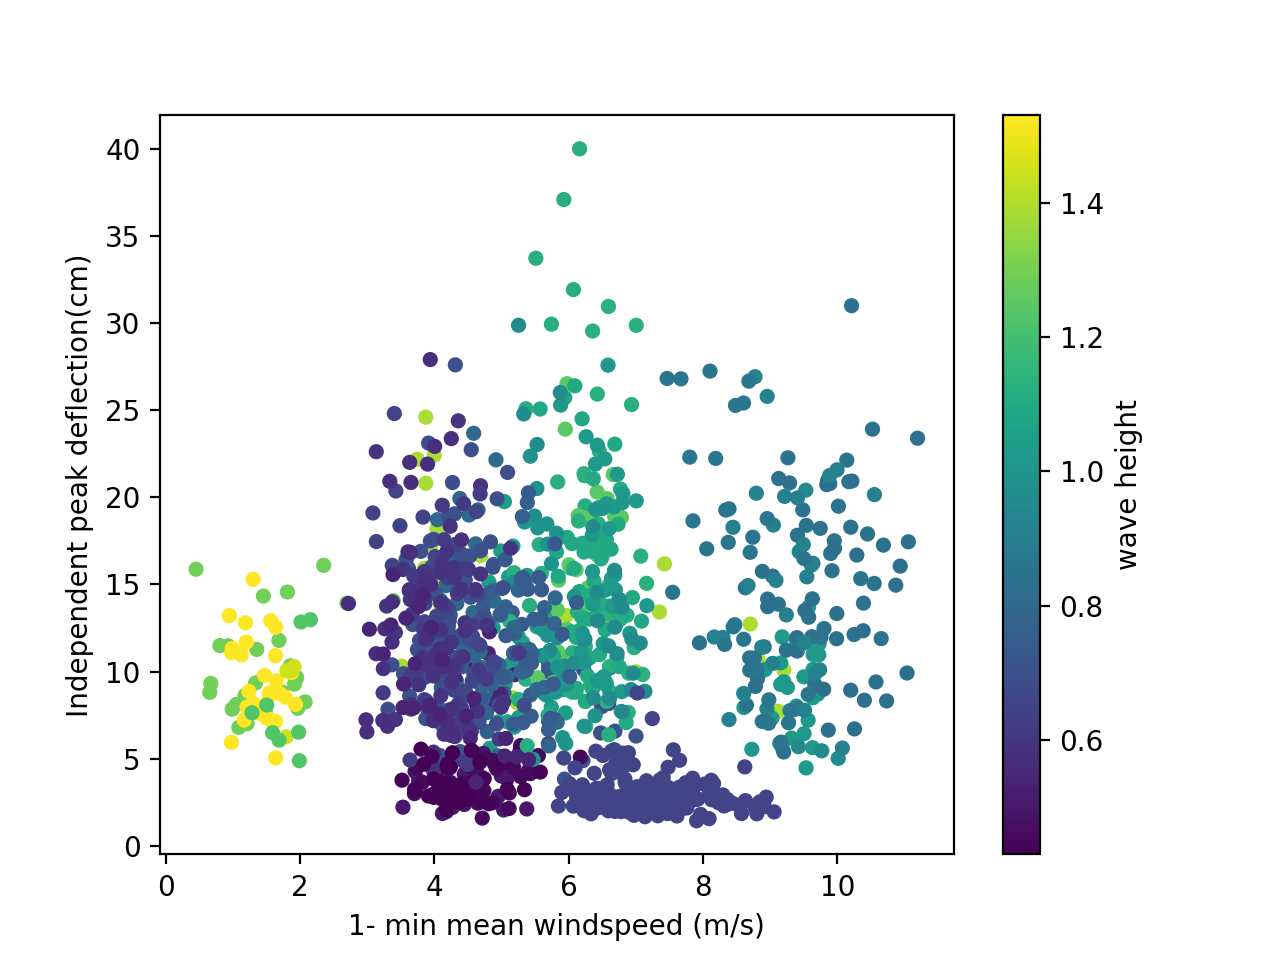

In [11]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.windSpeed, data.peakDeflectionTower, s=20, c=data.waveHeight)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='wave height')

<IPython.core.display.Javascript object>


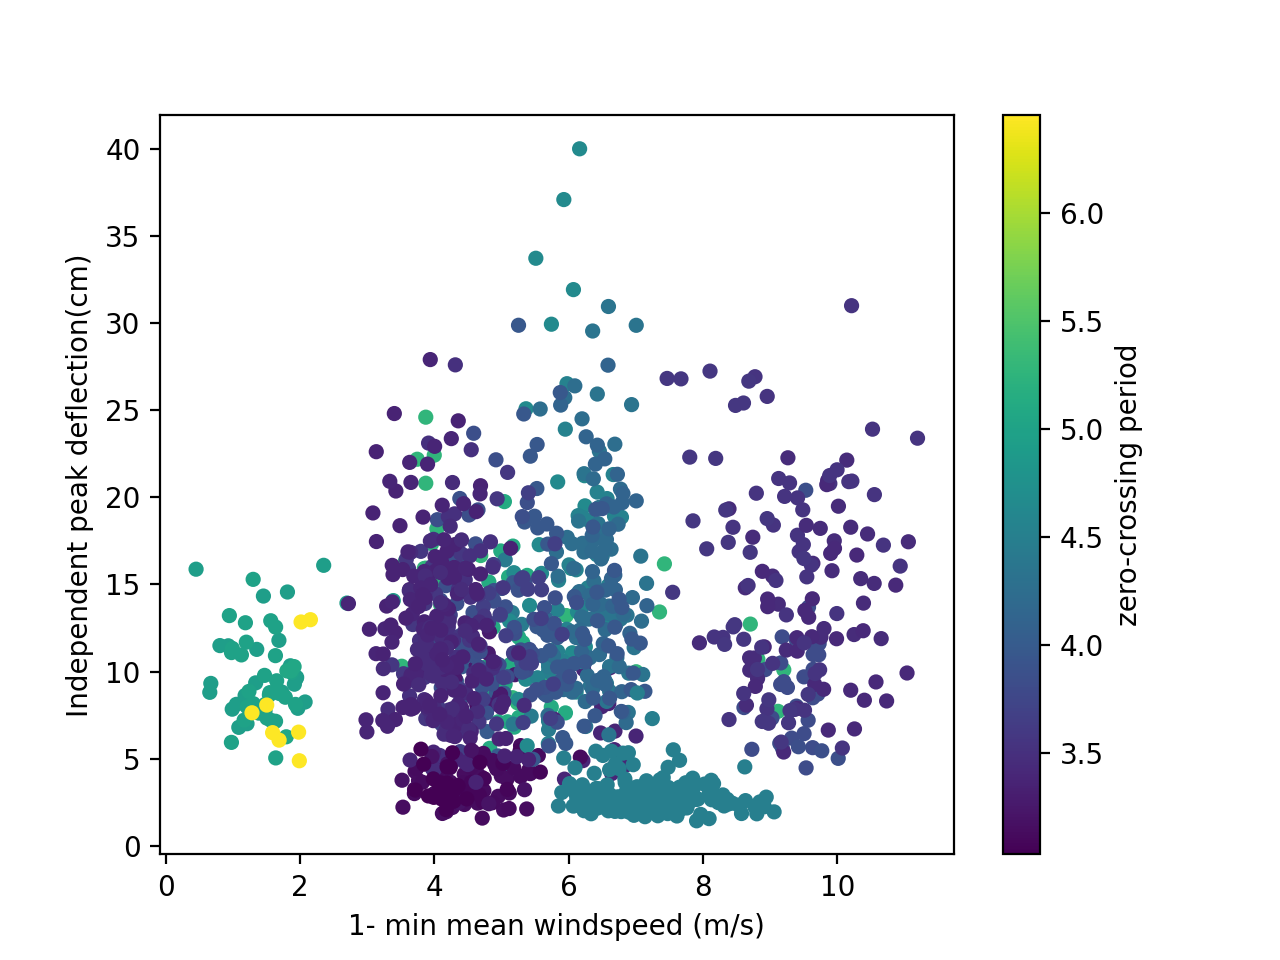

In [12]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.windSpeed, data.peakDeflectionTower, s=20, c=data.waveTz)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='zero-crossing period')

<IPython.core.display.Javascript object>


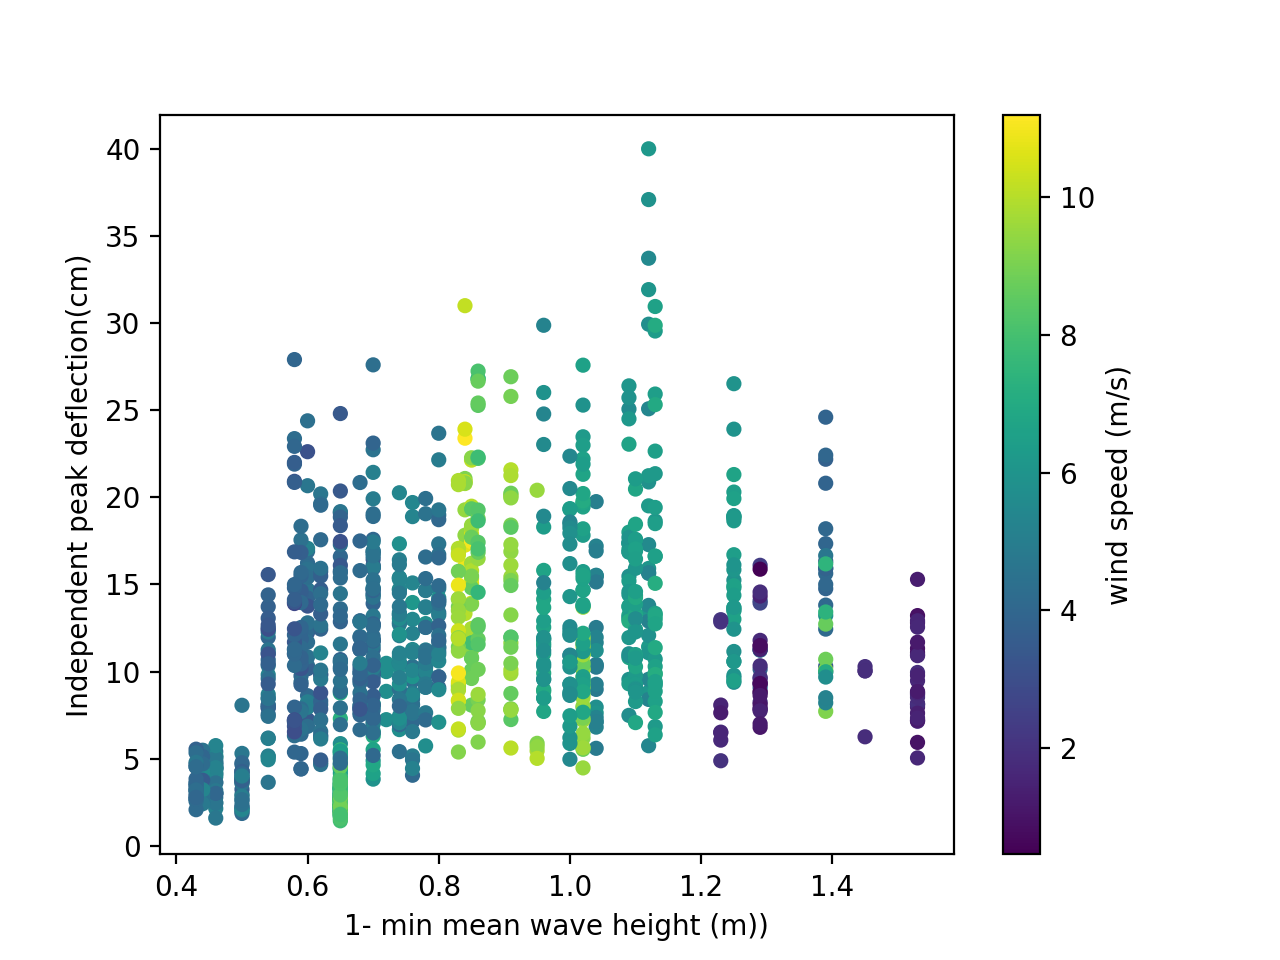

In [13]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.waveHeight, data.peakDeflectionTower, s=20, c=data.windSpeed)
ax1.set_xlabel('1- min mean wave height (m))')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='wind speed (m/s)')

<IPython.core.display.Javascript object>


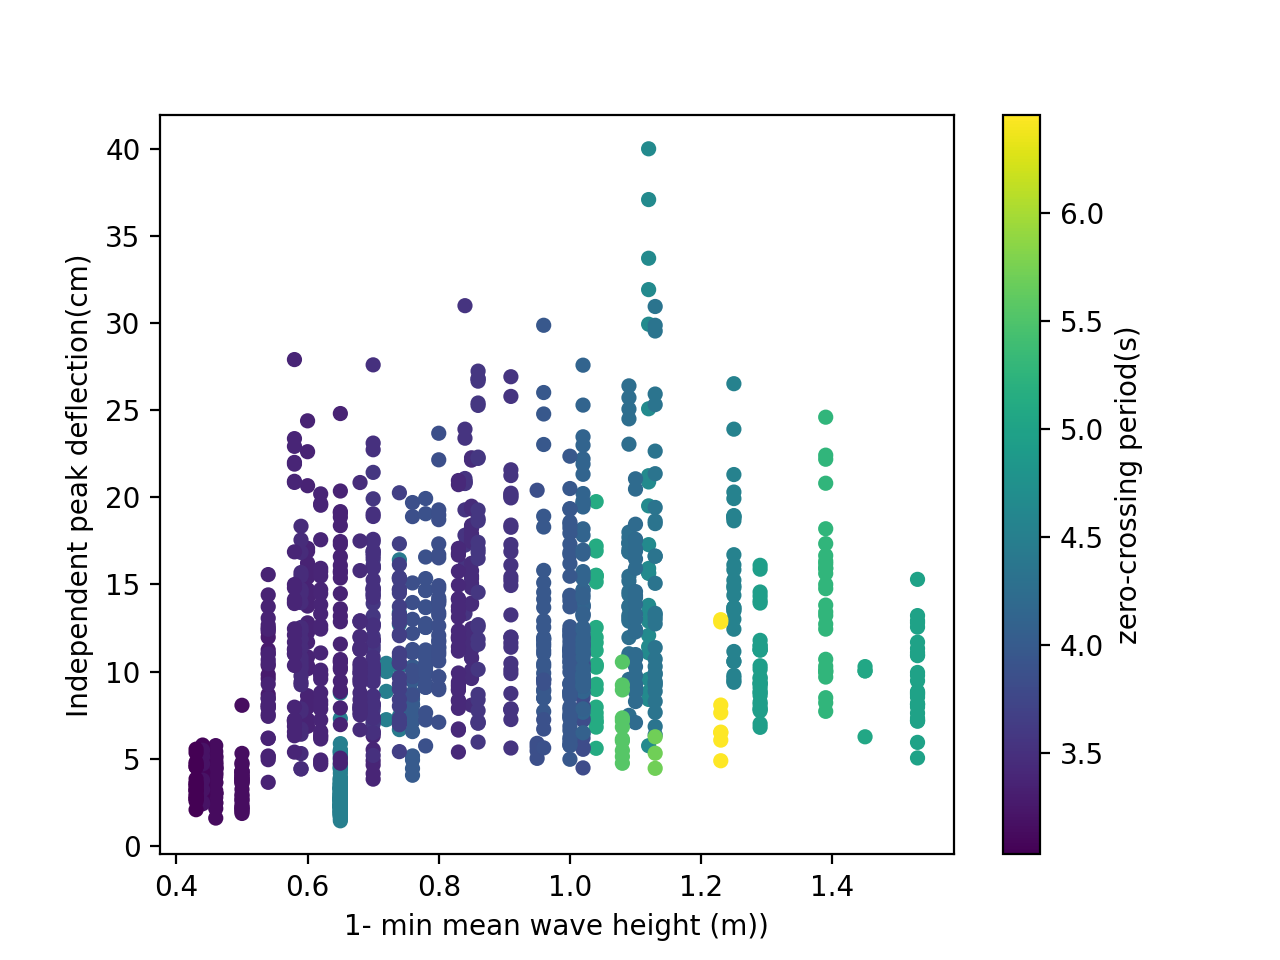

In [15]:
fig, ax1 = plt.subplots(1)
scatter= ax1.scatter(data.waveHeight, data.peakDeflectionTower, s=20, c=data.waveTz)
ax1.set_xlabel('1- min mean wave height (m))')
ax1.set_ylabel('Independent peak deflection(cm)')
fig.colorbar(scatter,label='zero-crossing period(s)')

<IPython.core.display.Javascript object>


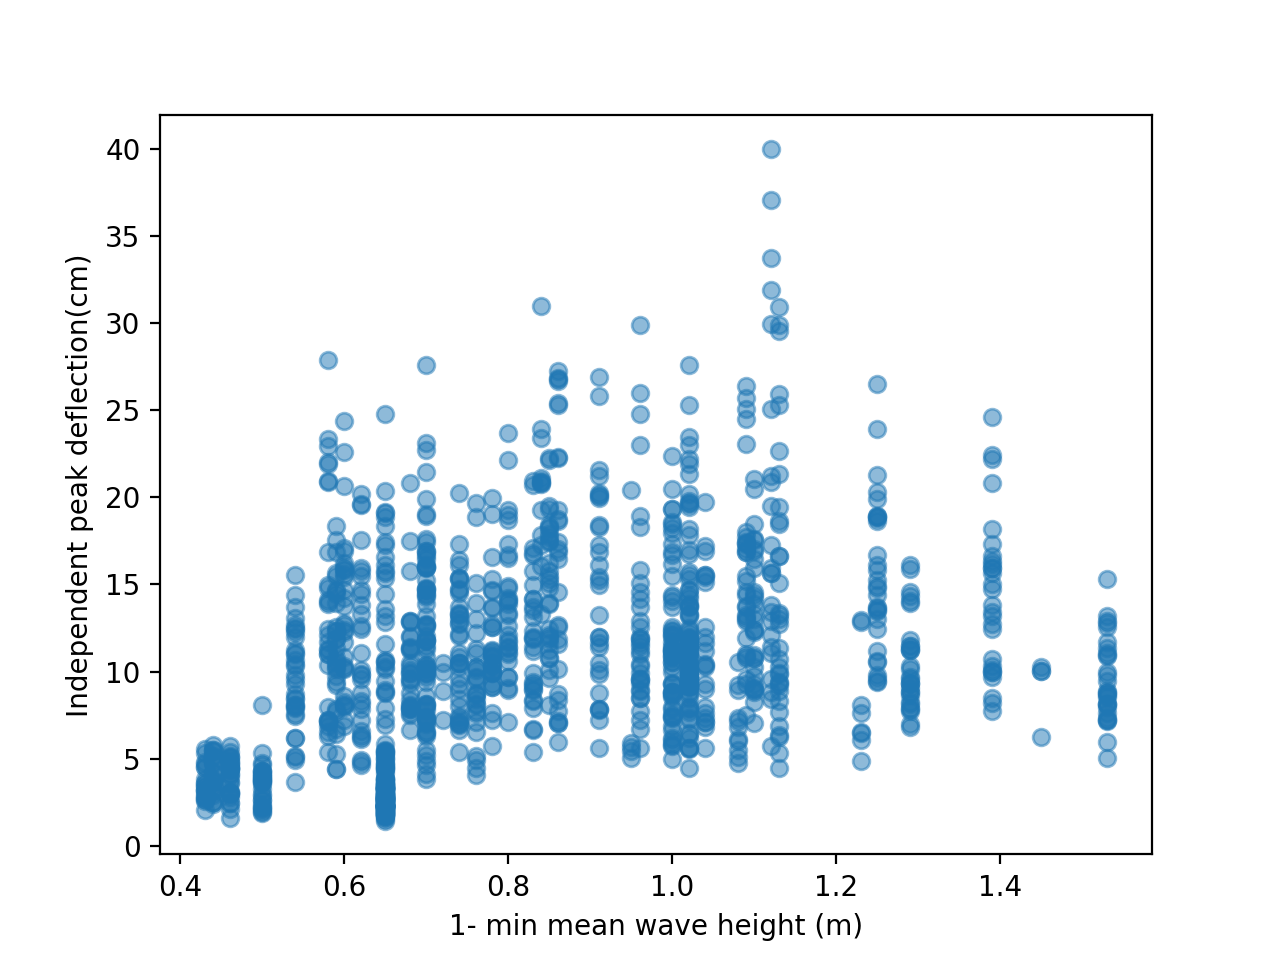

Text(0, 0.5, 'Independent peak deflection(cm)')

In [17]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.waveHeight, data.peakDeflectionTower, alpha= 0.5)
ax1.set_xlabel('1- min mean wave height (m)')
ax1.set_ylabel('Independent peak deflection(cm)')

<IPython.core.display.Javascript object>


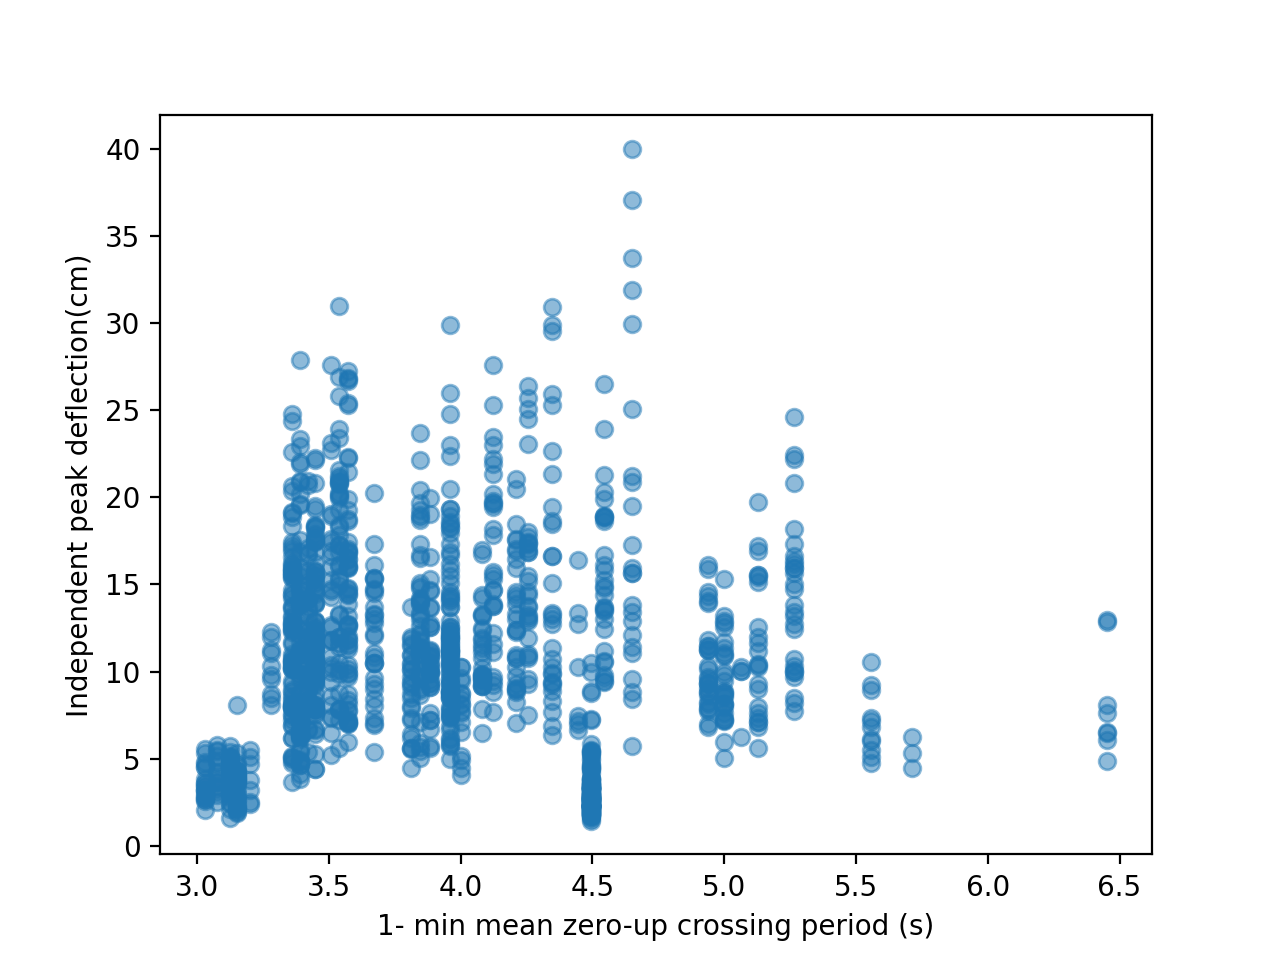

Text(0, 0.5, 'Independent peak deflection(cm)')

In [19]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.waveTz, data.peakDeflectionTower, alpha= 0.5)
ax1.set_xlabel('1- min mean zero-up crossing period (s)')
ax1.set_ylabel('Independent peak deflection(cm)')

# Interval Slicer

In [20]:
width_slicer_V = WidthOfIntervalSlicer(width=1, reference="right", min_n_points=1)
width_slicer_Hs = WidthOfIntervalSlicer(width=0.25, reference="right", min_n_points=1)
width_slicer_Tz = WidthOfIntervalSlicer(width=0.5, reference="right", min_n_points=1)

wind_slices, wind_references, wind_boundaries = width_slicer_V.slice_(data.windSpeed)
waveH_slices, waveH_references, waveH_boundaries = width_slicer_Hs.slice_(data.waveHeight)
waveTz_slices, waveTz_references, waveTz_boundaries = width_slicer_Tz.slice_(data.waveTz)

In [71]:
print(waveH_boundaries)
print(wind_boundaries)

[(0.375, 0.625), (0.625, 0.875), (0.875, 1.125), (1.125, 1.375), (1.375, 1.625)]
[(0.5, 1.5), (1.5, 2.5), (2.5, 3.5), (3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5), (10.5, 11.5)]


# Intervals Data 2

In [21]:
# WIND SPEED

#tower_defl_intervals_V= []
#for i in range (len(wind_references)):
    #tower_defl_intervals_V.append([])

#for i in range(len(wind_slices)):
    #for j in range(len(wind_slices[i])):
        #if (data2.windSpeed[j] >= wind_boundaries[i][0]) & (data2.windSpeed[j] < wind_boundaries[i][1]) :
            #tower_defl_intervals_V[i].append(data2.peakDeflectionTower[j])          
            
# WAVE HEIGHT


#tower_defl_intervals_Hs= []
#for i in range (len(waveH_references)):
    #tower_defl_intervals_Hs.append([])


#for i in range(len(waveH_slices)):
    #for j in range(len(waveH_slices[i])):
        #if (data2.waveHeight[j] >= waveH_boundaries[i][0]) & (data2.waveHeight[j] < waveH_boundaries[i][1]):
            #tower_defl_intervals_Hs[i].append(data2.peakDeflectionTower[j])
            
# WAVE ZERO-CROSSING PERIOD


#tower_defl_intervals_Tz= []
#for i in range (len(waveTz_references)):
    #tower_defl_intervals_Tz.append([])


#for i in range(len(waveTz_slices)):
    #for j in range(len(waveTz_slices[i])):
        #if (data2.waveTz[j] >= waveTz_boundaries[i][0]) & (data2.waveTz[j] < waveTz_boundaries[i][1]):
            #tower_defl_intervals_Tz[i].append(data2.peakDeflectionTower[j])

In [22]:
#for i in range(len(tower_defl_intervals_V)):
    #print(len(tower_defl_intervals_V[i]))

In [23]:
# Fit the parameters of the GEV conditional on intervals of V, Hs, Tz

# WIND SPEED

#parameter_list_tower_V= []
#for i in range (len(gev_fit_tower)):
    #parameter_list_tower_V.append([])

#for i in range(len(tower_defl_intervals_V)):
    #fit= stats.genextreme.fit(tower_defl_intervals_V[i])
    #parameter_list_tower_V[0].append(fit[0])
    #parameter_list_tower_V[1].append(fit[1])
    #parameter_list_tower_V[2].append(fit[2])

#print(len(parameter_list_tower_Vs[0]))

# WAVE HEIGHT

#parameter_list_tower_Hs= []
#for i in range (len(gev_fit_tower)):
    #parameter_list_tower_Hs.append([])

#for i in range(len(tower_defl_intervals_Hs)):
    #fit= stats.genextreme.fit(tower_defl_intervals_Hs[i])
    #parameter_list_tower_Hs[0].append(fit[0])
    #parameter_list_tower_Hs[1].append(fit[1])
    #parameter_list_tower_Hs[2].append(fit[2])

#print(len(parameter_list_tower_Hs[0]))

# ZERO CROSSING PERIOD

#parameter_list_tower_Tz= []
#for i in range (len(gev_fit_tower)):
    #parameter_list_tower_Tz.append([])

#for i in range(len(tower_defl_intervals_Tz)):
    #fit= stats.genextreme.fit(tower_defl_intervals_Tz[i])
    #parameter_list_tower_Tz[0].append(fit[0])
    #parameter_list_tower_Tz[1].append(fit[1])
    #parameter_list_tower_Tz[2].append(fit[2])

#print(len(parameter_list_tower_Tz[0]))

# Intervals data 1

In [24]:
# WIND SPEED

tower_defl_intervals_V= []
for i in range (len(wind_references)):
    tower_defl_intervals_V.append([])

for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]) :
            tower_defl_intervals_V[i].append(data.peakDeflectionTower[j])          
            
# WAVE HEIGHT


tower_defl_intervals_Hs= []
for i in range (len(waveH_references)):
    tower_defl_intervals_Hs.append([])


for i in range(len(waveH_slices)):
    for j in range(len(waveH_slices[i])):
        if (data.waveHeight[j] >= waveH_boundaries[i][0]) & (data.waveHeight[j] < waveH_boundaries[i][1]):
            tower_defl_intervals_Hs[i].append(data.peakDeflectionTower[j])
            
# WAVE ZERO-CROSSING PERIOD


tower_defl_intervals_Tz= []
for i in range (len(waveTz_references)):
    tower_defl_intervals_Tz.append([])


for i in range(len(waveTz_slices)):
    for j in range(len(waveTz_slices[i])):
        if (data.waveTz[j] >= waveTz_boundaries[i][0]) & (data.waveTz[j] < waveTz_boundaries[i][1]):
            tower_defl_intervals_Tz[i].append(data.peakDeflectionTower[j])

In [25]:
for i in range(len(tower_defl_intervals_V)):
    print(len(tower_defl_intervals_V[i]))

29
35
30
292
213
206
156
67
82
63
12


In [26]:
# Fit the parameters of the GEV conditional on intervals of V, Hs, Tz

# WIND SPEED

parameter_list_tower_V= []
for i in range (len(gev_fit_tower)):
    parameter_list_tower_V.append([])

for i in range(len(tower_defl_intervals_V)):
    fit= stats.genextreme.fit(tower_defl_intervals_V[i])
    parameter_list_tower_V[0].append(fit[0])
    parameter_list_tower_V[1].append(fit[1])
    parameter_list_tower_V[2].append(fit[2])

print(len(parameter_list_tower_V[0]))

# WAVE HEIGHT

parameter_list_tower_Hs= []
for i in range (len(gev_fit_tower)):
    parameter_list_tower_Hs.append([])

for i in range(len(tower_defl_intervals_Hs)):
    fit= stats.genextreme.fit(tower_defl_intervals_Hs[i])
    parameter_list_tower_Hs[0].append(fit[0])
    parameter_list_tower_Hs[1].append(fit[1])
    parameter_list_tower_Hs[2].append(fit[2])

print(len(parameter_list_tower_Hs[0]))

# ZERO CROSSING PERIOD

parameter_list_tower_Tz= []
for i in range (len(gev_fit_tower)):
    parameter_list_tower_Tz.append([])

for i in range(len(tower_defl_intervals_Tz)):
    fit= stats.genextreme.fit(tower_defl_intervals_Tz[i])
    parameter_list_tower_Tz[0].append(fit[0])
    parameter_list_tower_Tz[1].append(fit[1])
    parameter_list_tower_Tz[2].append(fit[2])

print(len(parameter_list_tower_Tz[0]))

11
5
7


# Dependency Shape parameter

<IPython.core.display.Javascript object>


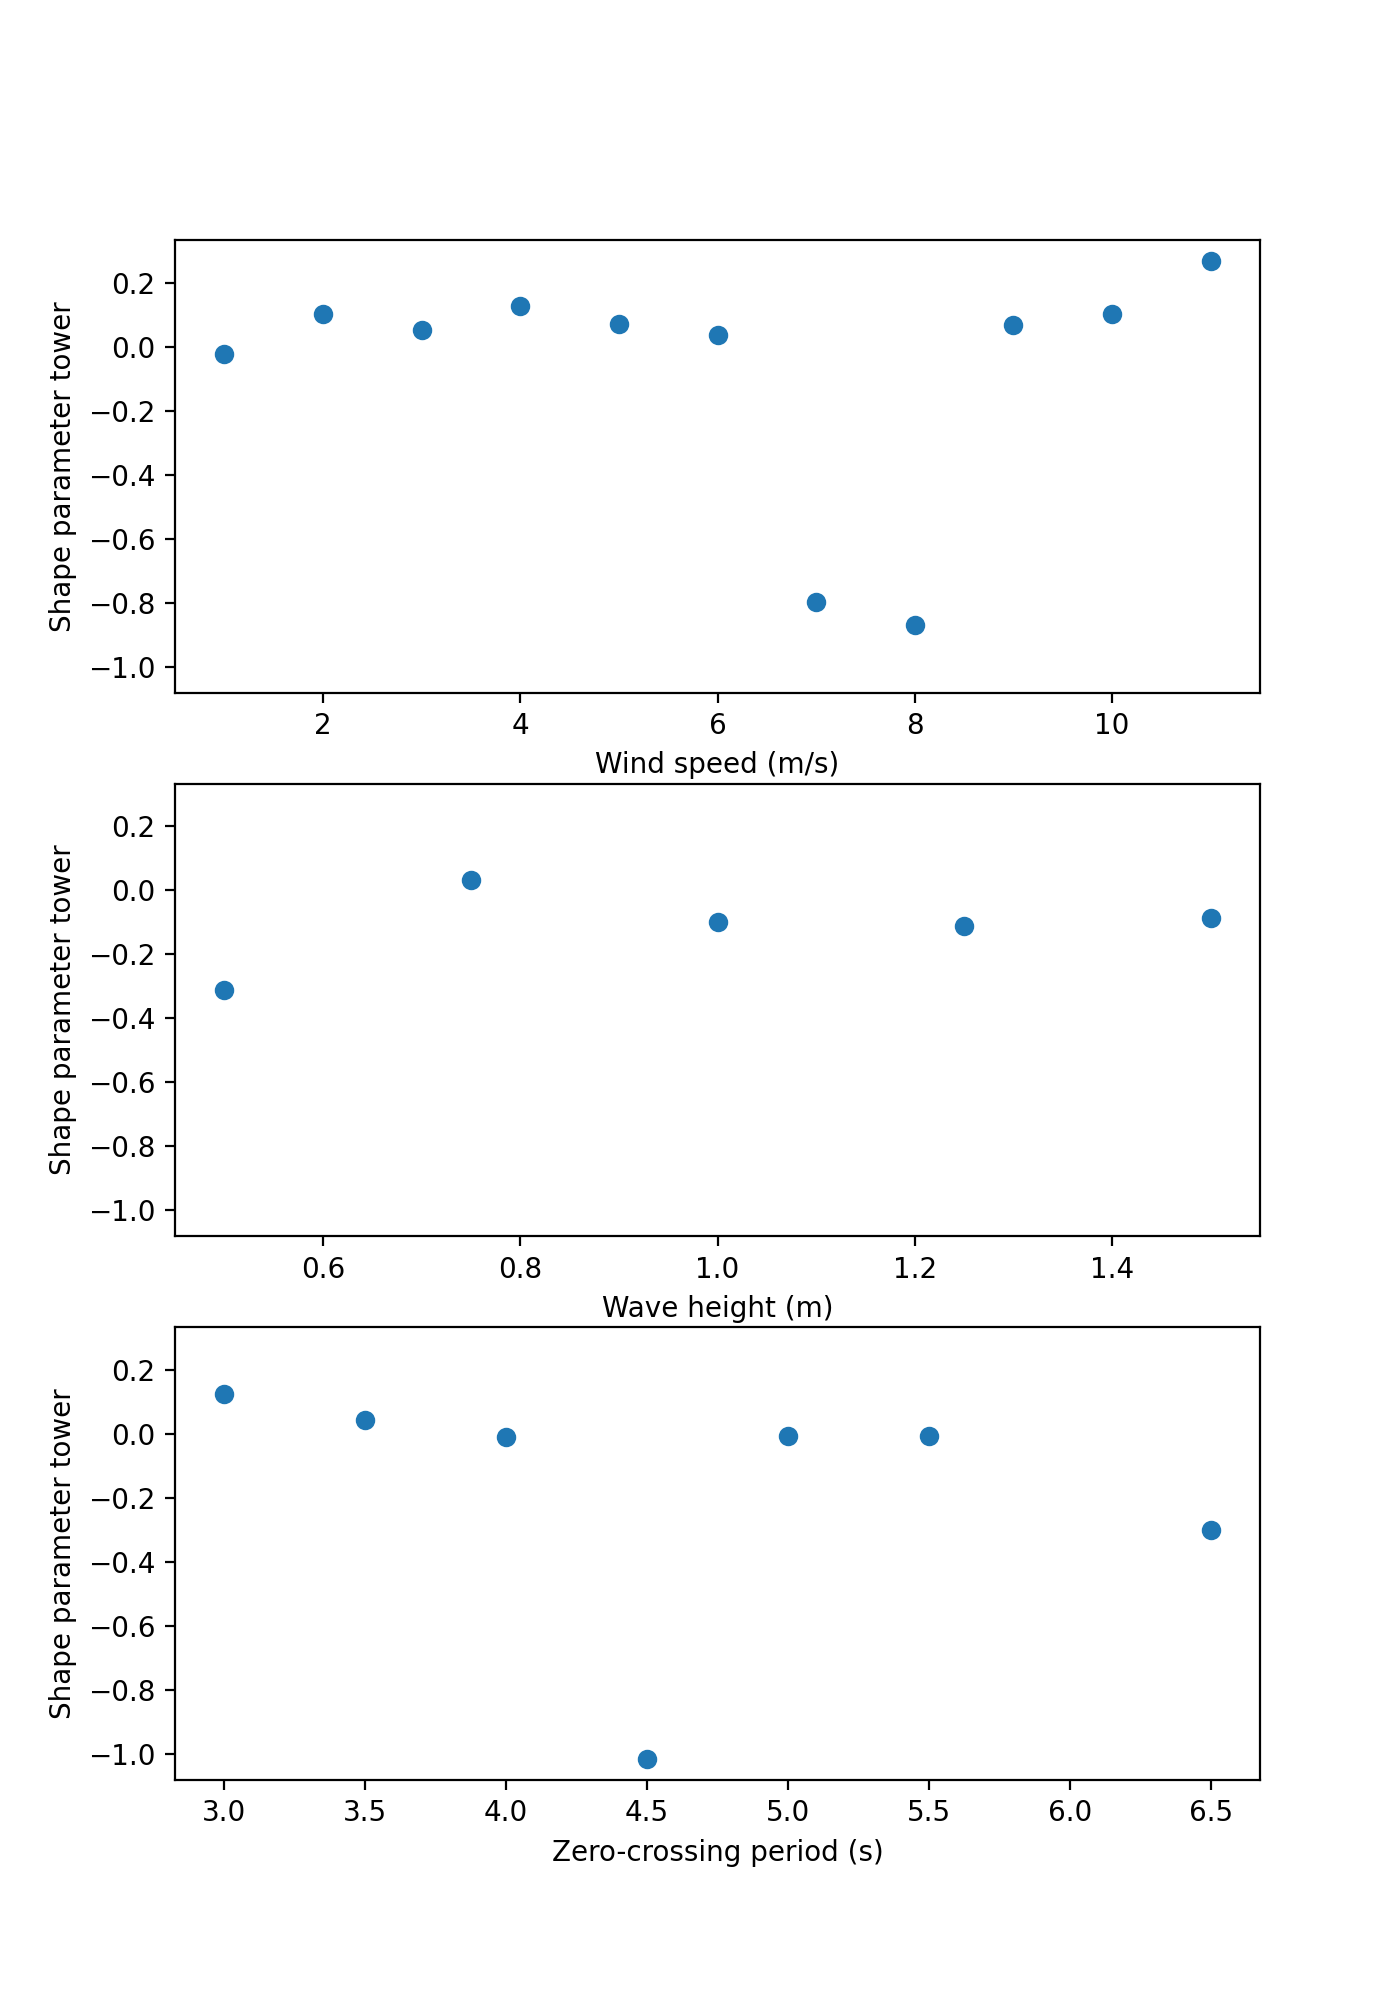

Text(0, 0.5, 'Shape parameter tower')

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= False, figsize=(7,10))
ax1.scatter(wind_references, parameter_list_tower_V[0])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter tower')
ax2.scatter(waveH_references, parameter_list_tower_Hs[0])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Shape parameter tower')
ax3.scatter(waveTz_references, parameter_list_tower_Tz[0])
ax3.set_xlabel('Zero-crossing period (s)')
ax3.set_ylabel('Shape parameter tower')

In [28]:
#plt.figure()
#plt.scatter(wind_references, parameter_list_tower_V[0])
#plt.ylabel('Shape Parameter value ')
#plt.xlabel('Wind speed')

In [29]:
#plt.figure()
#plt.scatter(waveH_references, parameter_list_tower_Hs[0])
#plt.ylabel('Shape Parameter value ')
#plt.xlabel('Wave height')

In [30]:
#plt.figure()
#plt.scatter(waveTz_references, parameter_list_tower_Tz[0])
#plt.ylabel('Shape Parameter value ')
#plt.xlabel('Zero up-crossing period')

# Dependency Location parameter

<IPython.core.display.Javascript object>


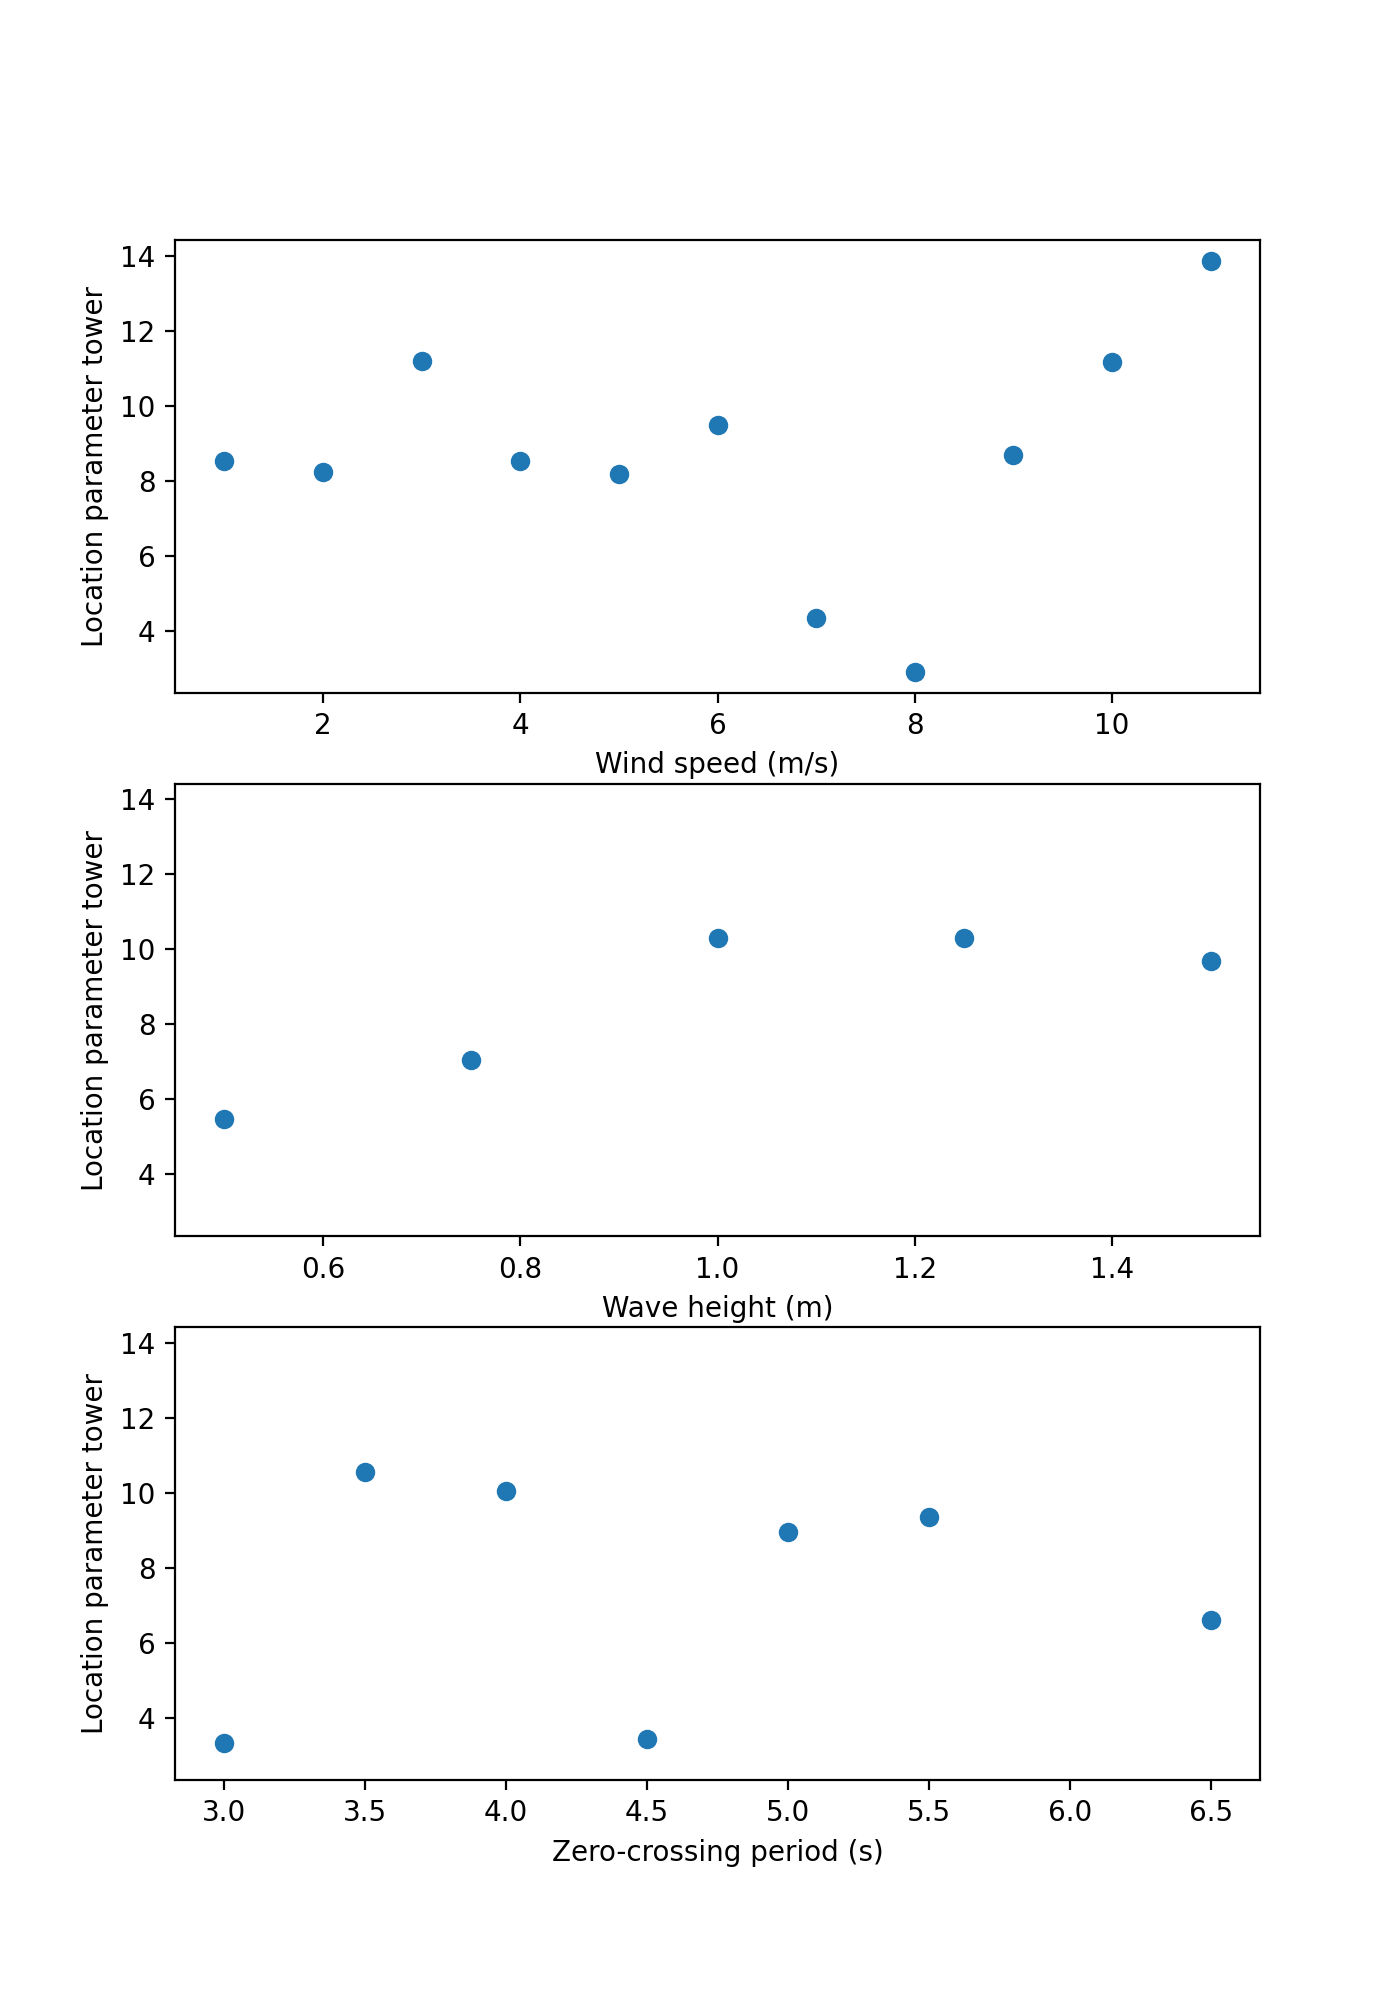

Text(0, 0.5, 'Location parameter tower')

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= False, figsize=(7,10))
ax1.scatter(wind_references, parameter_list_tower_V[1])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Location parameter tower')
ax2.scatter(waveH_references, parameter_list_tower_Hs[1])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Location parameter tower')
ax3.scatter(waveTz_references, parameter_list_tower_Tz[1])
ax3.set_xlabel('Zero-crossing period (s)')
ax3.set_ylabel('Location parameter tower')

# Dependency Scale parameter

<IPython.core.display.Javascript object>


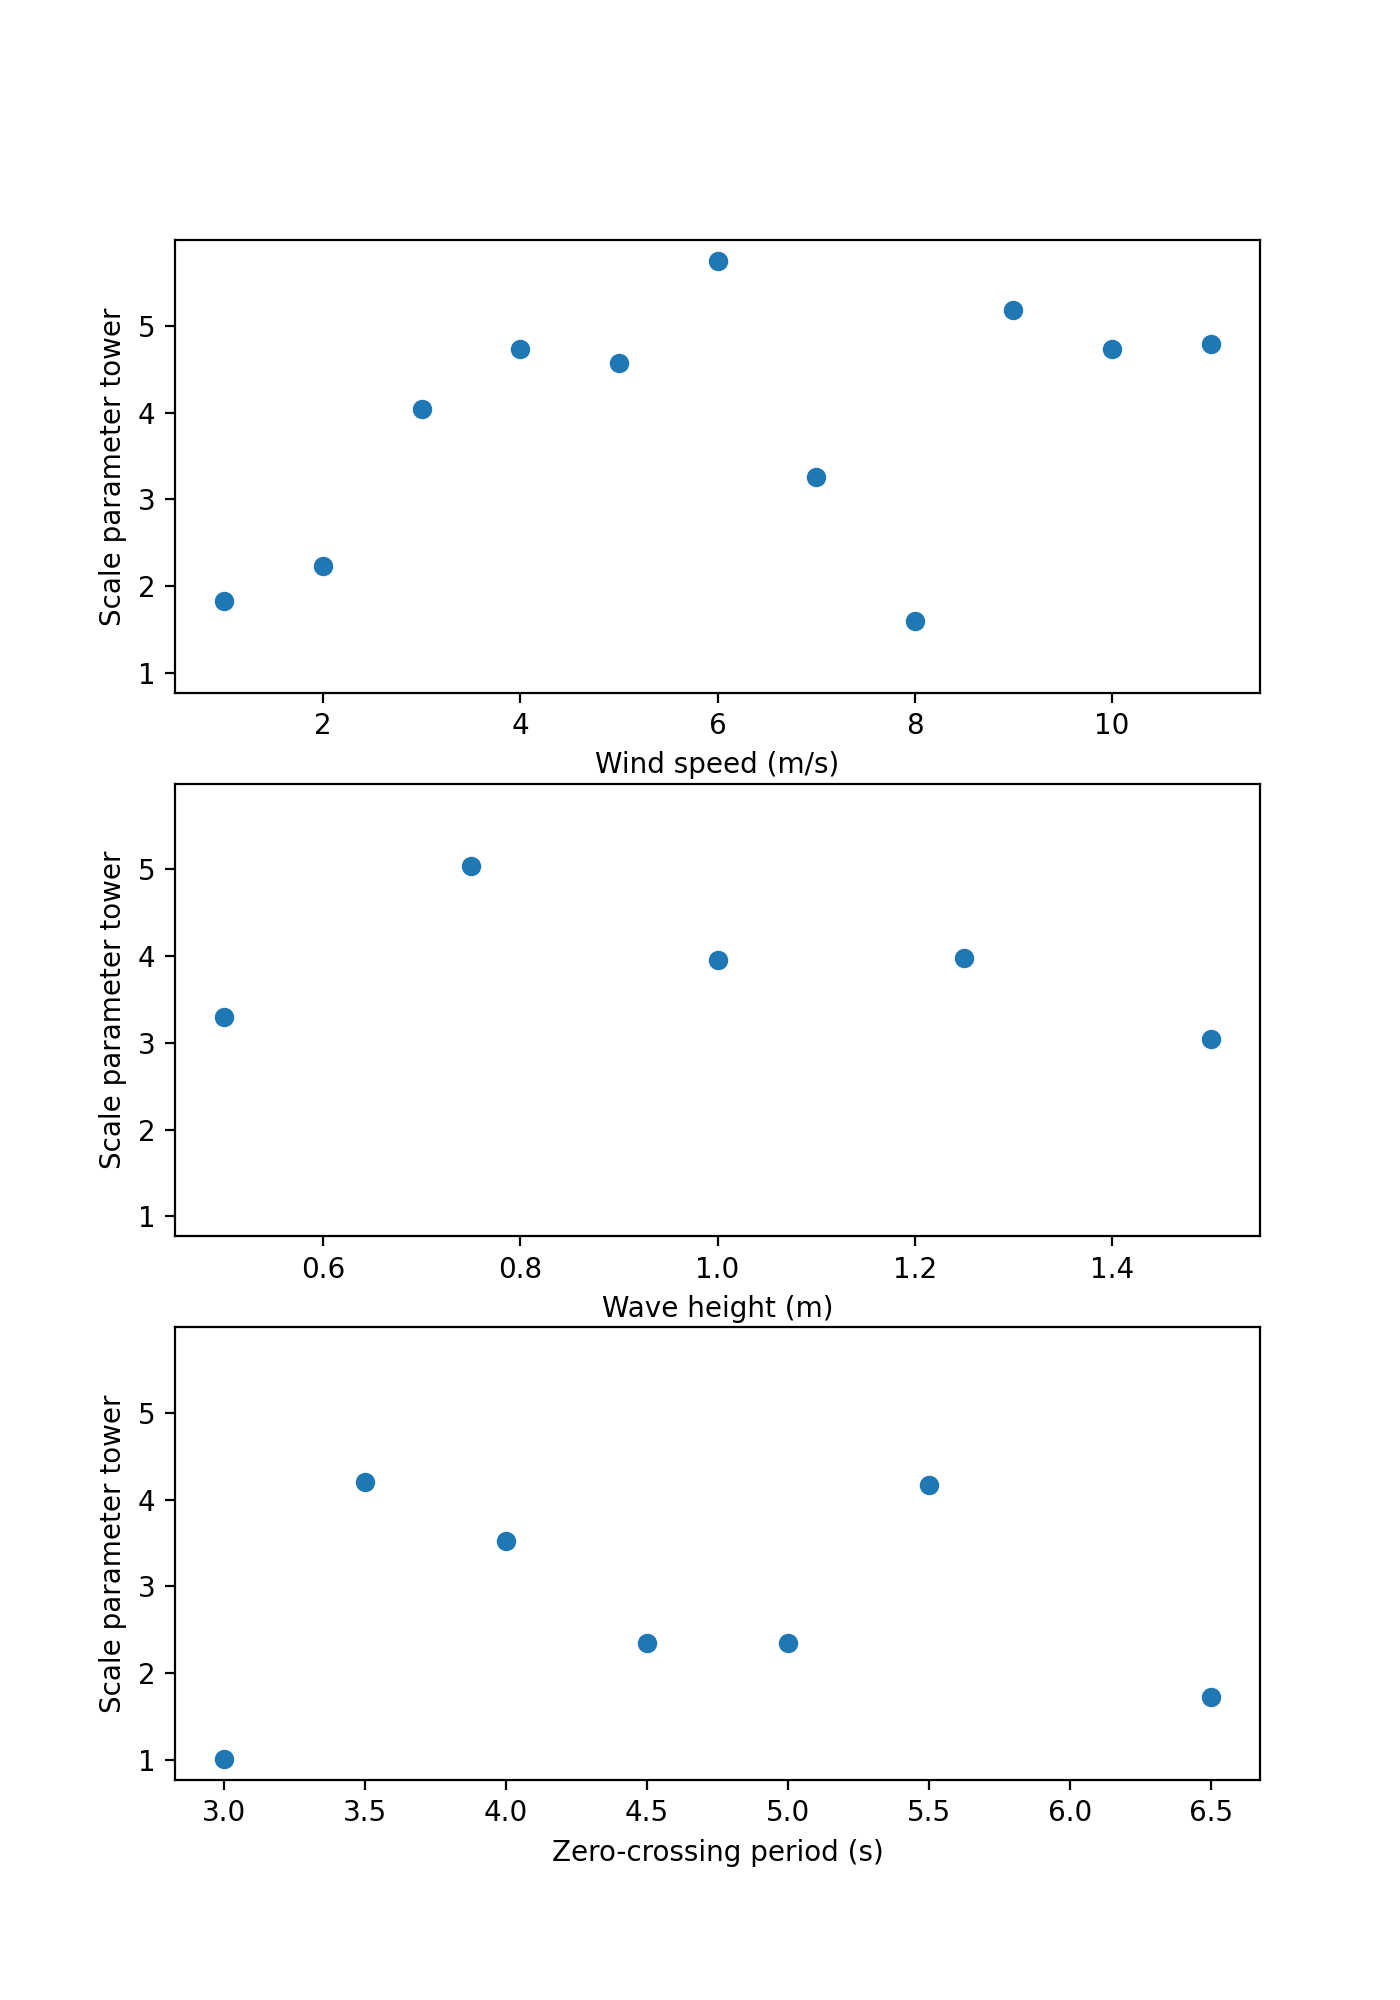

Text(0, 0.5, 'Scale parameter tower')

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= False, figsize=(7,10))
ax1.scatter(wind_references, parameter_list_tower_V[2])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Scale parameter tower')
ax2.scatter(waveH_references, parameter_list_tower_Hs[2])
ax2.set_xlabel('Wave height (m)')
ax2.set_ylabel('Scale parameter tower')
ax3.scatter(waveTz_references, parameter_list_tower_Tz[2])
ax3.set_xlabel('Zero-crossing period (s)')
ax3.set_ylabel('Scale parameter tower')

# Correlation coefficients

In [33]:
# WIND

r_shape_wind = np.corrcoef(parameter_list_tower_V[0], wind_references)
r_location_wind = np.corrcoef(parameter_list_tower_V[1], wind_references)
r_scale_wind = np.corrcoef(parameter_list_tower_V[2], wind_references)
print(r_shape_wind)
print(r_location_wind)
print(r_scale_wind)

[[ 1.         -0.10721592]
 [-0.10721592  1.        ]]
[[1.         0.15685331]
 [0.15685331 1.        ]]
[[1.         0.43475779]
 [0.43475779 1.        ]]


In [34]:
# WAVE HEIGHT

r_shape_waveH = np.corrcoef(parameter_list_tower_Hs[0], waveH_references)
r_location_waveH = np.corrcoef(parameter_list_tower_Hs[1], waveH_references)
r_scale_waveH = np.corrcoef(parameter_list_tower_Hs[2], waveH_references)
print(r_shape_waveH)
print(r_location_waveH)
print(r_scale_waveH)

[[1.         0.39263539]
 [0.39263539 1.        ]]
[[1.         0.84270182]
 [0.84270182 1.        ]]
[[ 1.         -0.32385028]
 [-0.32385028  1.        ]]


In [35]:
# ZERO CROSSING PERIOD

r_shape_waveTz = np.corrcoef(parameter_list_tower_Tz[0], waveTz_references)
r_location_waveTz = np.corrcoef(parameter_list_tower_Tz[1], waveTz_references)
r_scale_waveTz = np.corrcoef(parameter_list_tower_Tz[2], waveTz_references)
print(r_shape_waveTz)
print(r_location_waveTz)
print(r_scale_waveTz)

[[ 1.         -0.26180075]
 [-0.26180075  1.        ]]
[[1.         0.12427325]
 [0.12427325 1.        ]]
[[ 1.         -0.00601732]
 [-0.00601732  1.        ]]


# Dependence Functions

In [36]:
# Define dependence functions

def _power3(x, a, b, c):
    return a + b * x ** c
def _linear(x, a, b):
    return x * a + b
def _exp3(x, a, b, c):
    return a + b * np.exp(c * x)


bounds_3p = [(None, None), (None, None), (None, None)]
bounds_2p = [(None, None), (None, None)]
exp_bounds = [(0, None), (0, None), (None, None)]

power3 = DependenceFunction(_power3, bounds_3p, latex="$a + b * x^c$")
linear = DependenceFunction(_linear, latex="$a + b * x$")
exp3 = DependenceFunction(_exp3, bounds=exp_bounds)

In [37]:
#shape_param_fit= linear.fit(wind_references, parameter_list[0])
#print(shape_param_fit)

#linear.fit(wind_references, parameter_list[0])
#print(linear)

### WIND

In [38]:
wind_ref= np.asarray(wind_references)
shape_wind= np.asarray(parameter_list_tower_V[0])
location_wind= np.asarray(parameter_list_tower_V[1])
scale_wind= np.asarray(parameter_list_tower_V[2])

print(shape_wind)

[-0.02340525  0.10423975  0.05322464  0.12827194  0.07259961  0.03844346
 -0.79742099 -0.86795617  0.06975188  0.10255301  0.26978701]


In [39]:
linear_param_wind1 = fit_function(linear, wind_ref, shape_wind, (1, 1), "lsq", None, None)
linear_param_wind2 = fit_function(linear, wind_ref, location_wind, (1, 1), "lsq", None, None)
linear_param_wind3 = fit_function(linear, wind_ref, scale_wind, (1, 1), "lsq", None, None)
print(linear_param_wind1)
print(linear_param_wind2)
print(linear_param_wind3)

[-0.01230619 -0.00342751]
[0.14406715 7.78414756]
[0.18750554 2.75758953]


<IPython.core.display.Javascript object>


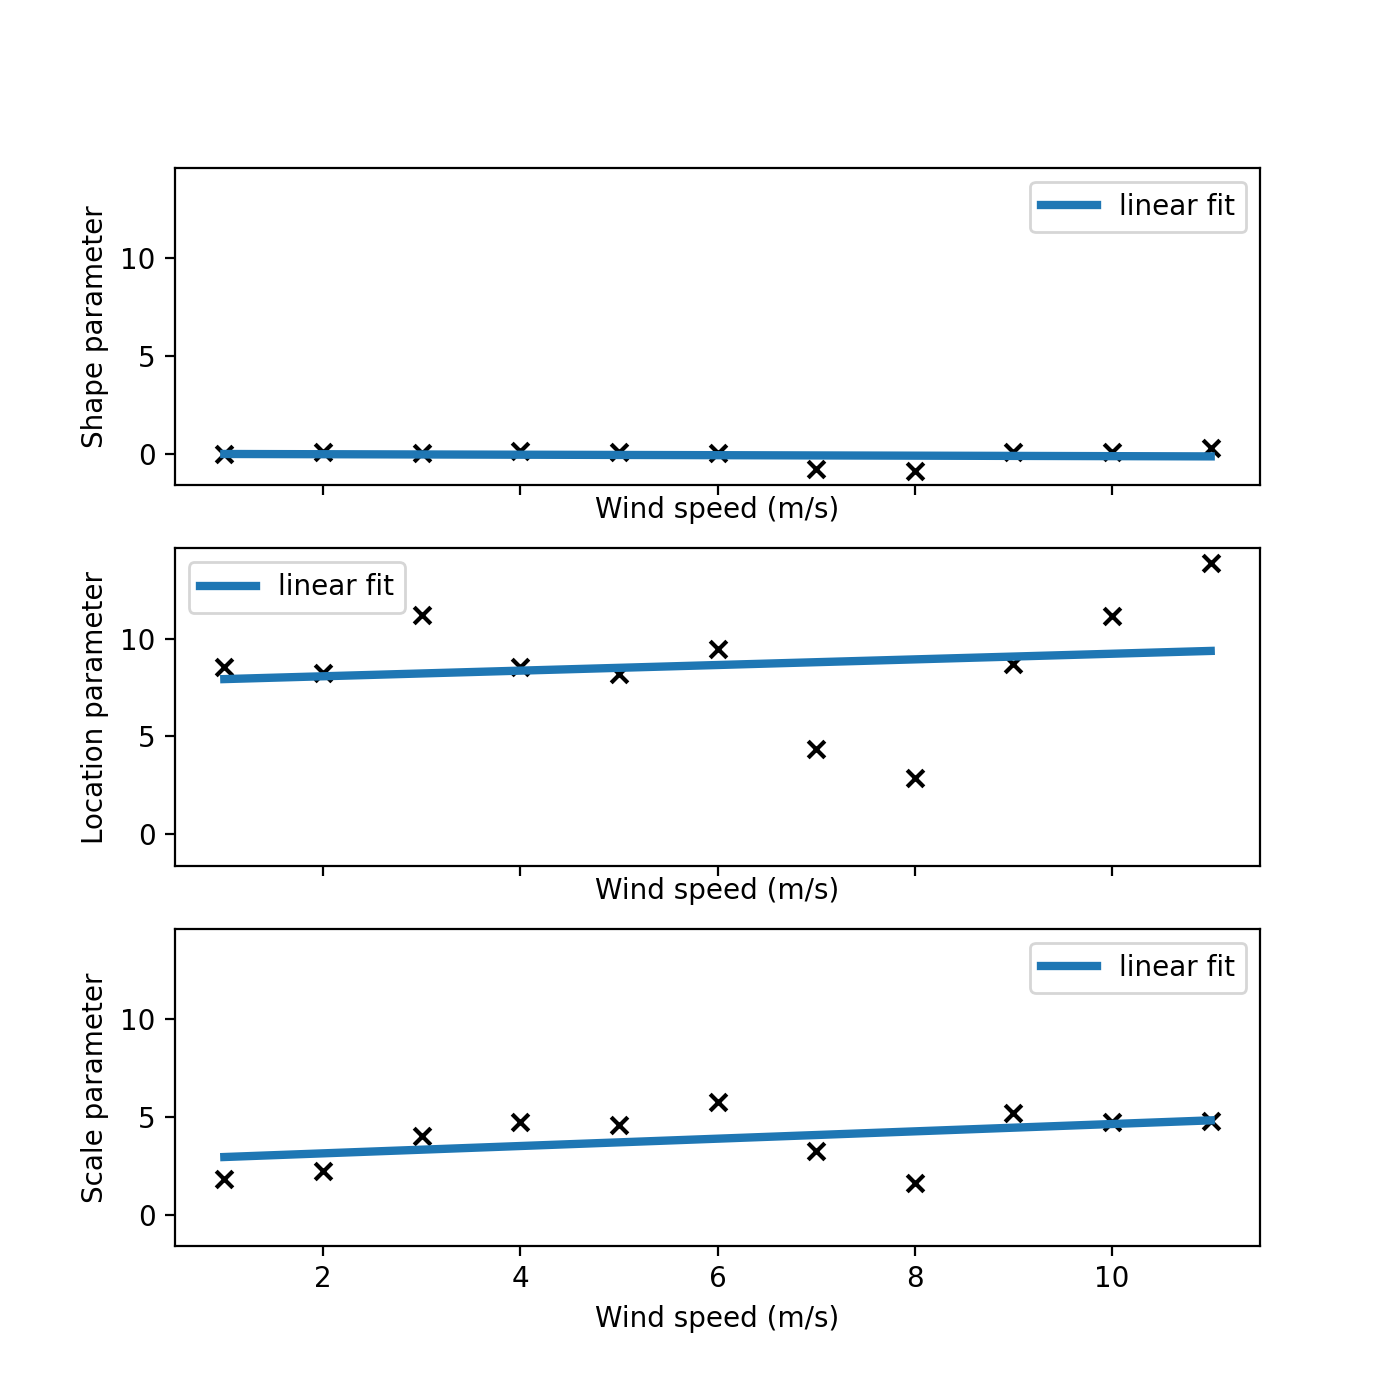

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(wind_ref, shape_wind, marker="x", c="k")
ax1.plot(wind_ref, linear(wind_ref, *linear_param_wind1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(wind_ref, location_wind, marker="x", c="k")
ax2.plot(wind_ref, linear(wind_ref, *linear_param_wind2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(wind_ref, scale_wind, marker="x", c="k")
ax3.plot(wind_ref, linear(wind_ref, *linear_param_wind3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

### WAVE HEIGHT

In [41]:
waveH_ref= np.asarray(waveH_references)
shape_waveH= np.asarray(parameter_list_tower_Hs[0])
location_waveH= np.asarray(parameter_list_tower_Hs[1])
scale_waveH= np.asarray(parameter_list_tower_Hs[2])

In [42]:
linear_param_waveH1 = fit_function(linear, waveH_ref, shape_waveH, (1, 1), "lsq", None, None)
linear_param_waveH2 = fit_function(linear, waveH_ref, location_waveH, (1, 1), "lsq", None, None)
linear_param_waveH3 = fit_function(linear, waveH_ref, scale_waveH, (1, 1), "lsq", None, None)
print(linear_param_waveH1)
print(linear_param_waveH2)
print(linear_param_waveH3)

[ 0.12364968 -0.23881103]
[4.66140384 3.90713485]
[-0.63468044  4.49733941]


<IPython.core.display.Javascript object>


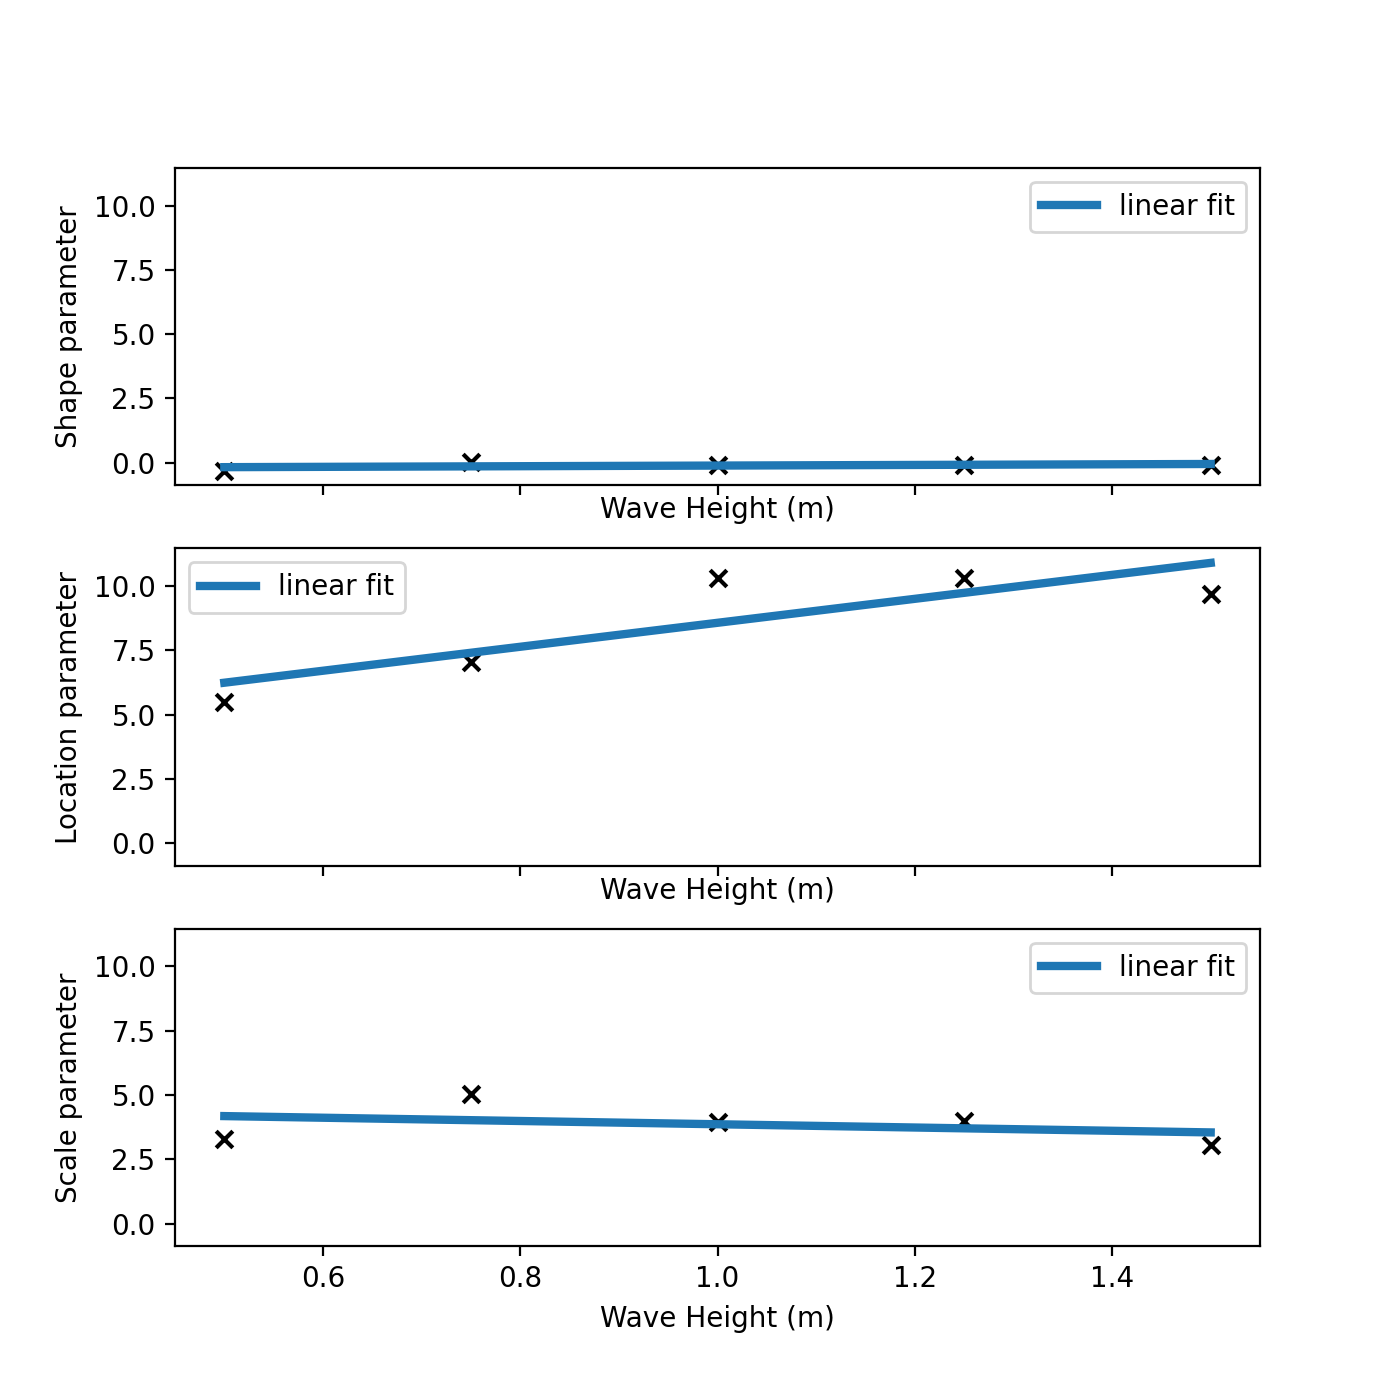

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(waveH_ref, shape_waveH, marker="x", c="k")
ax1.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wave Height (m)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(waveH_ref, location_waveH, marker="x", c="k")
ax2.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wave Height (m)')
ax2.set_ylabel('Location parameter')
ax3.scatter(waveH_ref, scale_waveH, marker="x", c="k")
ax3.plot(waveH_ref, linear(waveH_ref, *linear_param_waveH3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wave Height (m)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

### ZERO UP-CROSSING PERIOD

In [44]:
waveTz_ref= np.asarray(waveTz_references)
shape_waveTz= np.asarray(parameter_list_tower_Tz[0])
location_waveTz= np.asarray(parameter_list_tower_Tz[1])
scale_waveTz= np.asarray(parameter_list_tower_Tz[2])

In [45]:
linear_param_waveTz1 = fit_function(linear, waveTz_ref, shape_waveTz, (1, 1), "lsq", None, None)
linear_param_waveTz2 = fit_function(linear, waveTz_ref, location_waveTz, (1, 1), "lsq", None, None)
linear_param_waveTz3 = fit_function(linear, waveTz_ref, scale_waveTz, (1, 1), "lsq", None, None)
print(linear_param_waveTz1)
print(linear_param_waveTz2)
print(linear_param_waveTz3)

[-0.08626079  0.22707843]
[0.31463929 6.02691297]
[-0.00616106  2.78757499]


<IPython.core.display.Javascript object>


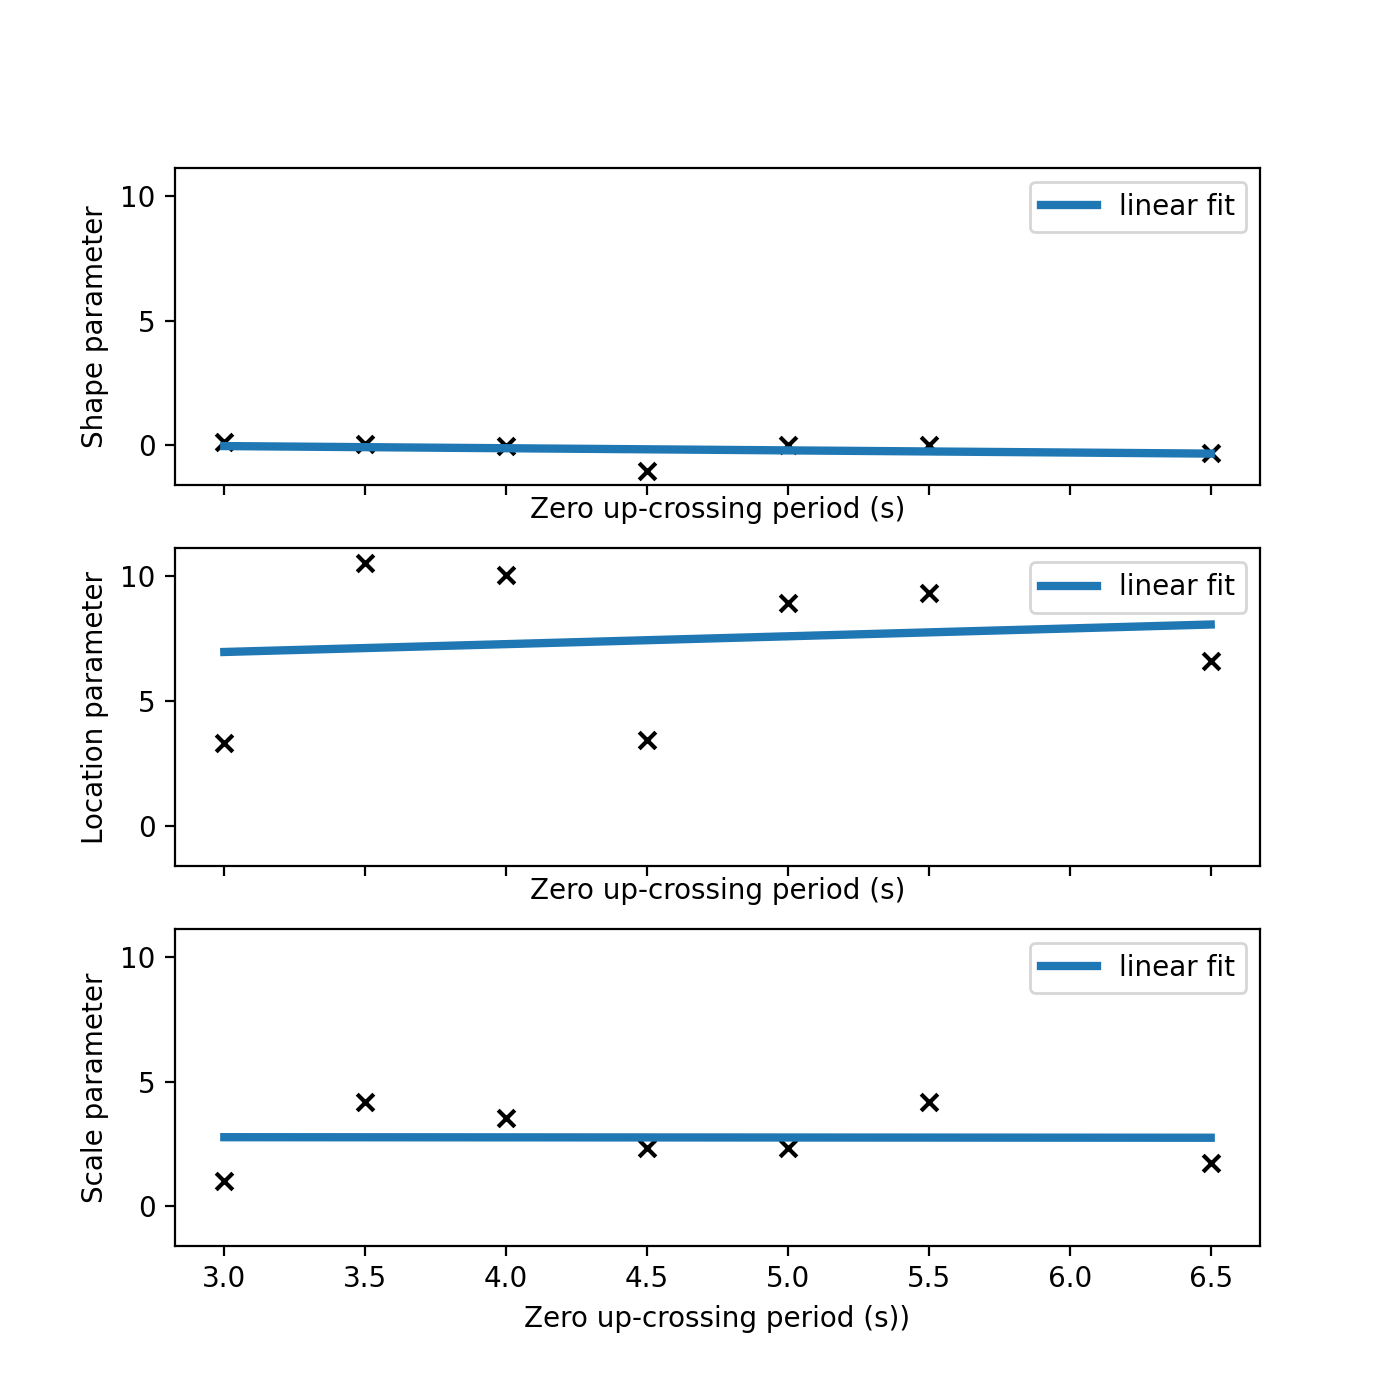

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(waveTz_ref, shape_waveTz, marker="x", c="k")
ax1.plot(waveTz_ref, linear(waveTz_ref, *linear_param_waveTz1), label="linear fit", linewidth=3)
ax1.set_xlabel('Zero up-crossing period (s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(waveTz_ref, location_waveTz, marker="x", c="k")
ax2.plot(waveTz_ref, linear(waveTz_ref, *linear_param_waveTz2), label="linear fit", linewidth=3)
ax2.set_xlabel('Zero up-crossing period (s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(waveTz_ref, scale_waveTz, marker="x", c="k")
ax3.plot(waveTz_ref, linear(waveTz_ref, *linear_param_waveTz3), label="linear fit", linewidth=3)
ax3.set_xlabel('Zero up-crossing period (s))')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

# Modell 1: R(Hs)

In [47]:
# Average scale and shape 

average_xi= shape_waveH.mean()
average_sigma= scale_waveH.mean()
print(average_xi)
print(average_sigma)

-0.11516134215922307
3.862658971492828


In [48]:
#def xi_func(hs):
    #return 0.124*hs -0.239
def mu_func(hs):
    return 4.661*hs +3.907
#def sigma_func(hs):
    #return -0.635*hs +4.497

In [49]:
#hs_grid = np.linspace(0,10,20)
#v_grid= np.linspace(0,25,20)
#r_grid= np.linspace(0,30,20)
#vmesh, hmesh = np.meshgrid(v_grid, hs_grid)

#print(hmesh)
#print(vmesh)

In [50]:
#xi= xi_func(hmesh)
#mu= mu_func(hmesh)
#sigma= sigma_func(hmesh )

#xi= xi_func(data.waveHeight)
mu= mu_func(data.waveHeight)
#sigma= sigma_func(data.waveHeight)

In [51]:
con_dist_Hs= stats.genextreme(average_xi, mu, average_sigma)
#cdf=joint_dist.cdf(r_grid)
#pdf=joint_dist.pdf(r_grid)
#rvs=joint_dist.rvs(size=(20,20))
rvs= con_dist_Hs.rvs(size=1272)
#print(con_dist_Hs)
print(rvs)

[11.05896191 11.03630437 22.71060897 ...  6.19646149  8.44067927
  8.07590829]


In [52]:
peak_defl_tower= pd.DataFrame.to_numpy(data.peakDeflectionTower)
print(peak_defl_tower)
model_error= peak_defl_tower-rvs
model_error= abs(model_error)
model_error_mean= model_error.mean()
print(model_error_mean)

[15.6301 17.3423 14.7588 ...  4.6835  4.7923  4.5329]
6.256685600168791


## Comparison real data and model

<IPython.core.display.Javascript object>


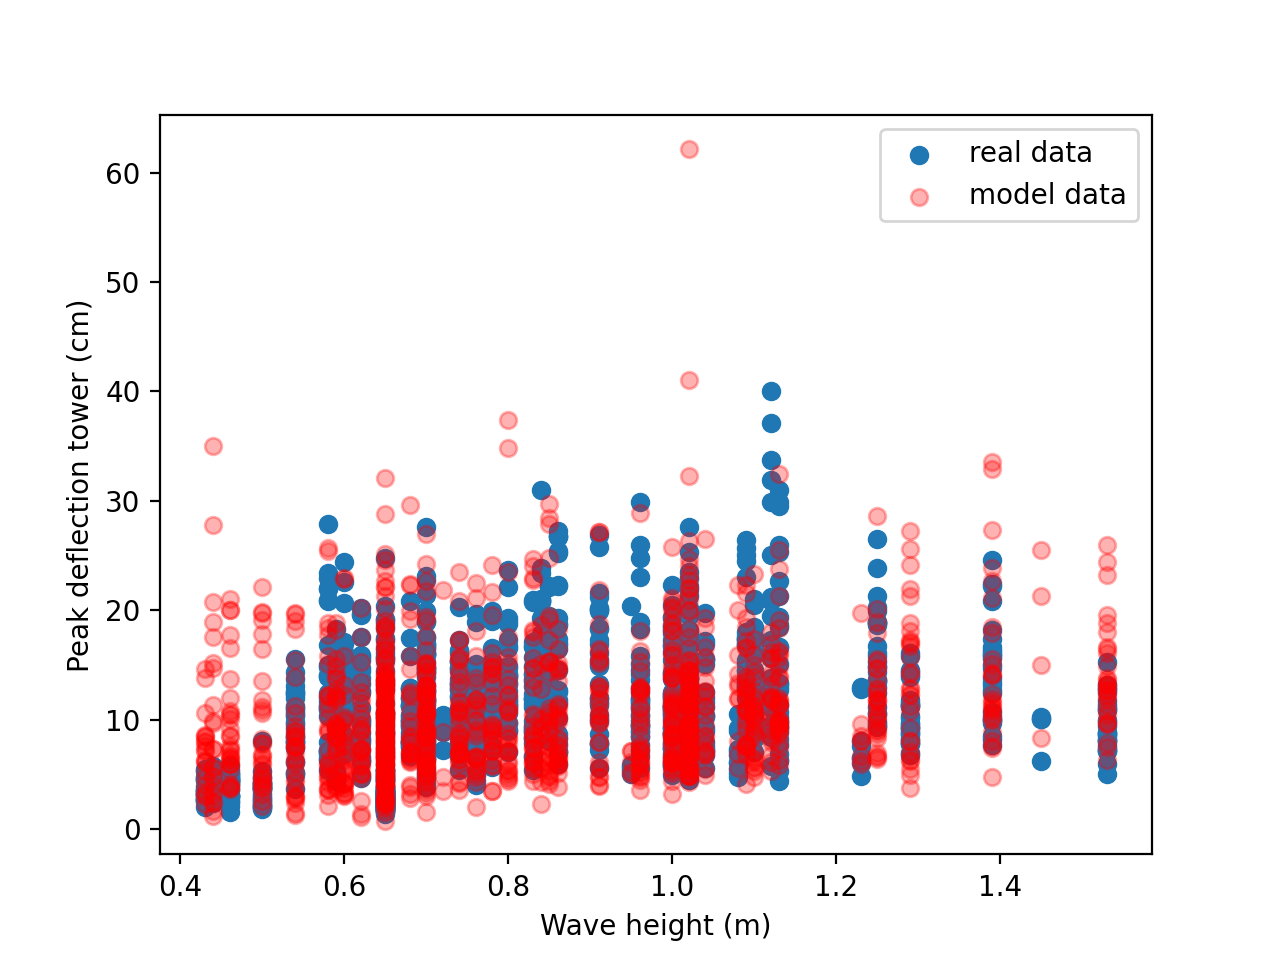

In [53]:
plt.figure()
plt.scatter(data.waveHeight, data.peakDeflectionTower, label='real data')
plt.scatter(data.waveHeight, rvs, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wave height (m)')
plt.ylabel('Peak deflection tower (cm)')
plt.legend()

In [54]:
#plt.figure()
#plt.plot(hs_grid,cdf)
#plt.plot(hs_grid,pdf)

# Modell 2: R(Hs,V)

Idee: 
- shape, location und scale parameter auf ein zweidimensionales Koordinatensystem aus hs und v intervallen fitten
- dann basierend auf den Intervallen eine gemeinsame Abhängigkeit (Ebene) fitten

<IPython.core.display.Javascript object>


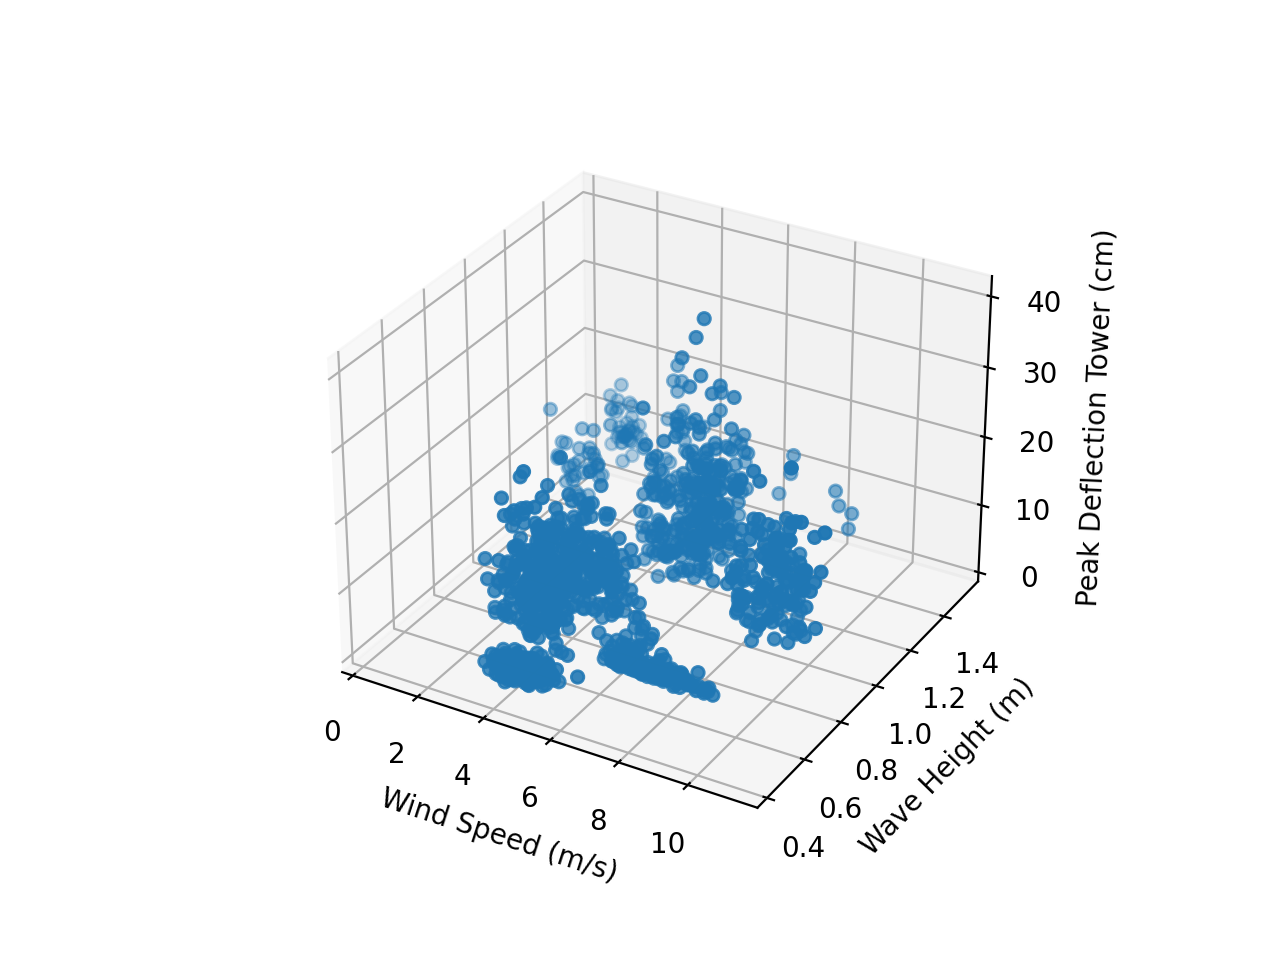

Text(0.5, 0, 'Peak Deflection Tower (cm)')

In [55]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = data.windSpeed
ys = data.waveHeight
zs = data.peakDeflectionTower
ax.scatter(xs, ys, zs)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Wave Height (m)')
ax.set_zlabel('Peak Deflection Tower (cm)')

In [130]:
width_slicer_V2 = WidthOfIntervalSlicer(width=2.5, reference="right", min_n_points=1)
width_slicer_Hs2 = WidthOfIntervalSlicer(width=0.5, reference="right", min_n_points=1)

wind_slices2, wind_references2, wind_boundaries2 = width_slicer_V2.slice_(data.windSpeed)
waveH_slices2, waveH_references2, waveH_boundaries2 = width_slicer_Hs2.slice_(data.waveHeight)

print(wind_boundaries2)
print(waveH_boundaries2)
print(type(len(wind_boundaries2)))

[(1.25, 3.75), (3.75, 6.25), (6.25, 8.75), (8.75, 11.25)]
[(0.25, 0.75), (0.75, 1.25), (1.25, 1.75)]
<class 'int'>


In [131]:
shape_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
shape_matrix[:] = np.NaN

scale_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
scale_matrix[:] = np.NaN

location_matrix = np.empty((len(wind_boundaries2), len(waveH_boundaries2)))
location_matrix[:] = np.NaN

print(location_matrix)

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


In [132]:
# This for loop does the following:
# 1. Find peak deflection data that are simultaneously in a certain interval of both hs and v 
# 2. Estimate the parameters of the GEV distribution of that specific interval
# 3. Sort the parameters into matrices of shape, scale and location parameter

for j in range (len(wind_references2)):
    for k in range (len(waveH_references2)):
        data_storage= []
        for i in range(len(data)):
            if ((data.windSpeed[i] >= wind_boundaries2[j][0]) & (data.windSpeed[i] < wind_boundaries2[j][1]) & (data.waveHeight[i] >= waveH_boundaries2[k][0]) & (data.waveHeight[i] < waveH_boundaries2[k][1]) ):
                data_storage.append(data.peakDeflectionTower[i])
        #print(data_storage)
        #print(len(data_storage))
        fit= stats.genextreme.fit(data_storage)
        shape_matrix[j][k]= fit[0]
        scale_matrix[j][k]= fit[1]
        location_matrix[j][k]= fit[2]

/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


In [134]:
print(shape_matrix)
print(scale_matrix)
print(location_matrix)

[[ 0.18761117 -0.29962407 -0.04681081]
 [ 0.00278386 -0.09601278 -0.04433881]
 [-0.26781445 -0.0216373   0.41397807]
 [ 0.17028866  0.04693509  1.04104583]]
[[ 9.77732064  6.60633705  8.95924317]
 [ 6.99071664 10.68021899 12.50113735]
 [ 2.51819107 12.32223731 14.62424583]
 [ 2.13302856 10.83308299 10.01472427]]
[[4.79941022 1.72485535 2.27513335]
 [4.24696952 4.04142214 3.58860702]
 [0.73430699 4.4096841  3.51867154]
 [0.2933954  4.54371678 0.71892098]]


In [110]:
#data_storage= np.array(data_storage)
print(data_storage)
#fit= stats.genextreme.fit(data_storage)

[]


In [73]:
#gridSize = len(data)
#v= np.linspace(0,12,10)
#hs= np.linspace(0,5,10)
#vgrid, hgrid = np.meshgrid(v, hs)
#print(len(vgrid))
#print(vgrid, hgrid)
#print(vgrid[0])
#print(hgrid[0])

In [74]:
#for i in range(len(data):
    #for j in range(len(vgrid)):
        #for k in range(len(vgrid[i])):
               #if (data.windSpeed[i]< vgrid[j][k+1] && data.windSpeed[i]>= vgrid[j][k]) && (data.waveHeight[i])< hgrid[j][k+1] && data.windSpeed[i]>= vgrid[j][k]
               

In [72]:
# sort data into meshgrid
#tower_defl_mesh = [[0 for k in range(len(v))] for j in range(len(hs))]
#for i in range (len(vgrid)):
    #for j in range (len(hgrid))
        #tower_defl_mesh.append([])
#print(tower_defl_mesh)

In [57]:
#print(max(data.windSpeed))
#print(max(data.waveHeight))

In [58]:
#xis = nan([size(vgrid), 4]);
#sigmas = nan([size(vgrid), 4]);
#mus = nan([size(vgrid), 4]);

In [59]:
#import scipy.io
#mat = scipy.io.loadmat('/Users/lenastroer/Python_Lokal/OvrDataEmulatorDiffSeed.mat')

In [60]:
#print(len(mat))
#print(shape(mat))
#print(type(mat))
#print(mat)

In [61]:
# WIND SPEED

#tower_defl_intervals_V= []
#for i in range (len(wind_references)):
    #tower_defl_intervals_V.append([])

#for i in range(len(wind_slices)):
    #for j in range(len(wind_slices[i])):
        #if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]) :
            #tower_defl_intervals_V[i].append(data.peakDeflectionTower[j])

In [102]:
#def func(X, a, b, c):
    #x,y = X
    #return np.log(a) + b*np.log(x) + c*np.log(y)

# some artificially noisy data to fit
#x = np.linspace(0.1,1.1,101)
#y = np.linspace(1.,2., 101)
#a, b, c = 10., 4., 6.
#z = func((x,y), a, b, c) * 1 + np.random.random(101) / 100

# initial guesses for a,b,c:
#p0 = 8., 2., 7.
#curve=curve_fit(func, (x,y), z, p0)
#print(curve)

In [49]:
#def func(X, a, b, c, d):
  #  x,y = X
    #return (a*x+b)+(c*y+d)

# data to fit

#x = waveH_ref
#y = wind_ref
#z = parameter_list_tower_V[0]

# initial guesses for a,b,c:
#p0 = 8., 2., 7.
#print(curve_fit(func, (x,y), z, p0))

## Fit plane

<IPython.core.display.Javascript object>


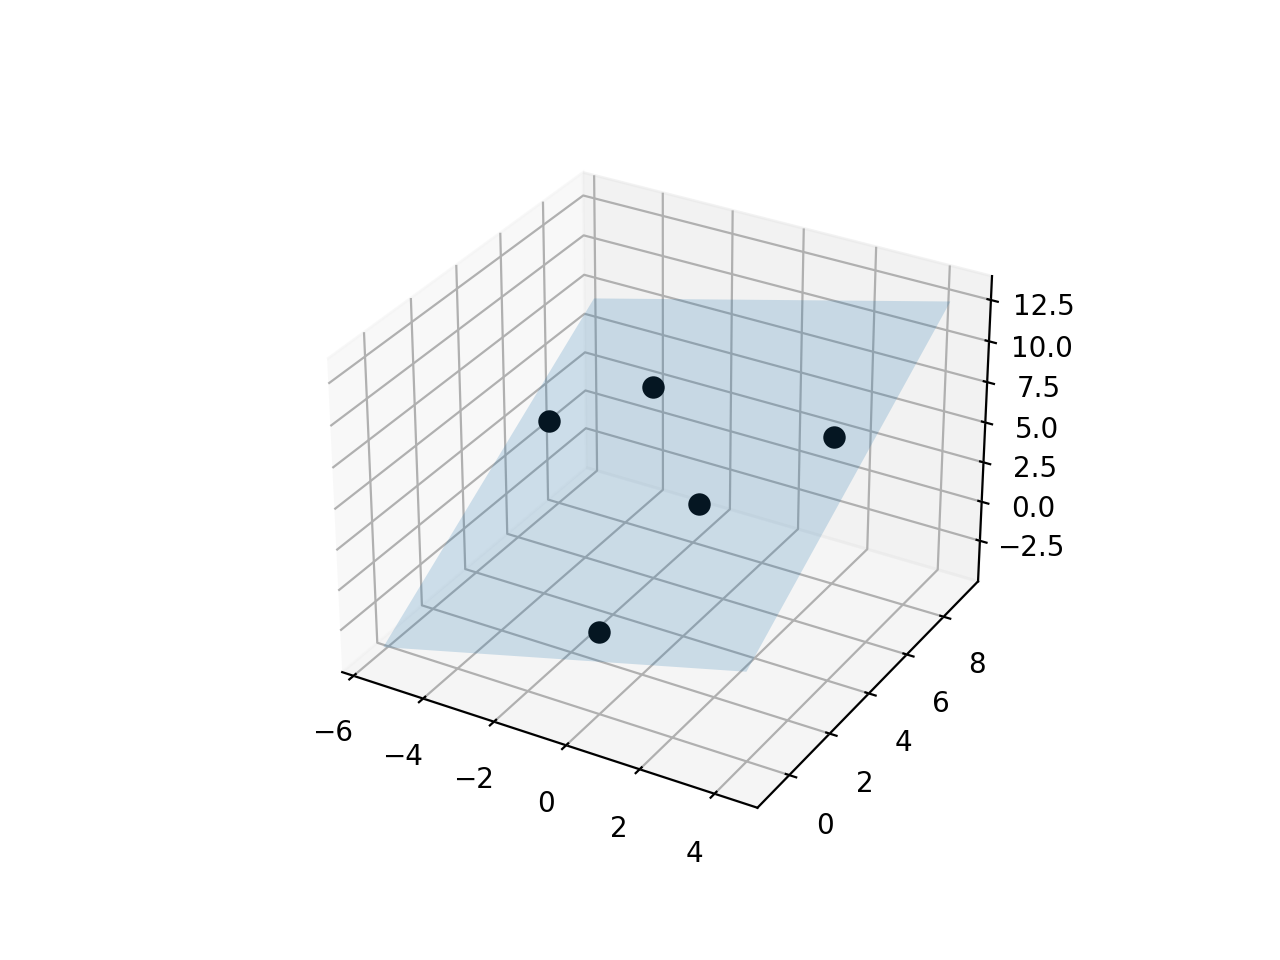

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot:>)

In [70]:
points = Points([[0, 0, 0], [1, 3, 5], [-5, 6, 3], [3, 6, 7], [-2, 6, 7]])

plane = Plane.best_fit(points)


plot_3d(
    points.plotter(c='k', s=50, depthshade=False),
    plane.plotter(alpha=0.2, lims_x=(-5, 5), lims_y=(-5, 5)),
)

# Andreas Ansatz

In [76]:
class ResponseEmulator:
    """"
    ResponseEmulator Emulates the deflection of a wind turbine's tower and SBIT during installation.
    The distribution describes 1-min maxima. 1-hour maxima are also available as 1-min maxima were 
    converted.
    
    """
    
    def CDF1min(hs, r):
        xi_func= 0.103*hs -0.228
        mu_func= 6.650*hs +1.328
        sigma_func= 1.124*hs +2.253
        
        pdf= stats.genextreme.pdf(r, xi_func, mu_func, sigma_func)
        return pdf
    
    def CDF1hr(hs, r):
        xi_func= 0.103*hs -0.228
        mu_func= 6.650*hs +1.328
        sigma_func= 1.124*hs +2.253
        
        maxima_per_hour = 60
        cdf= stats.genextreme.cpdf(r, xi_func, mu_func, sigma_func)
        cdf = cdf^maxima_per_hour;
        return cdf

In [83]:
R=ResponseEmulator()

#hs_temp = np.linspace(0,10,20)
#v_temp= np.linspace(0,25,50)
#h_mesh,v_mesh= np.meshgrid(hs_temp, v_temp)

#sigmas = R.sigma(vmesh, hmesh);
#mus = R.mu(vmesh, hmesh);
#rmedian = R.ICDF1hr(vmesh, hmesh, 0.5);

In [89]:
median_r= ResponseEmulator.CDF1min(hs_temp, 0.5)
print(median_r)

[1.63848318e-01 8.02791999e-03 3.55705556e-06 1.30755036e-09
 2.27335458e-11 1.44173164e-11 5.98421814e-11 4.66567923e-10
 3.70934295e-09 2.38011898e-08 1.16210004e-07 4.36573655e-07
 1.30563415e-06 3.22775527e-06 6.82637528e-06 1.27136906e-05
 2.13513044e-05 3.29551717e-05 4.74673014e-05 6.45862253e-05]
